In [144]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import chi2
from sklearn.preprocessing import StandardScaler, PowerTransformer, QuantileTransformer
import sklearn.covariance as cov
from sklearn.metrics import silhouette_score
from sklearn.model_selection import cross_val_score
from sklearn.cluster import KMeans, AgglomerativeClustering
from yellowbrick.cluster import KElbowVisualizer
from random import randint
from itertools import combinations
from mpl_toolkits.mplot3d import Axes3D
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
from matplotlib import colors as mcolors
from scipy.cluster.hierarchy import dendrogram, linkage, set_link_color_palette
from sompy.sompy import SOMFactory # SOM
import warnings
import logging

from matplotlib.colors import ListedColormap, LinearSegmentedColormap

warnings.filterwarnings('ignore')
logging.getLogger('matplotlib.font_manager').disabled = True
log = logging.getLogger()
log.setLevel(logging.CRITICAL)

# Data preparation

## Reading and formatting

In [145]:
# Short info about data
df = pd.read_pickle('../data/data.pkl')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1798 entries, 0 to 378
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   TVD      1798 non-null   float64
 1   GR       1798 non-null   float64
 2   WNKT     1798 non-null   float64
 3   DTP      1798 non-null   float64
 4   well_id  1798 non-null   object 
 5   DS_diff  835 non-null    float64
dtypes: float64(5), object(1)
memory usage: 98.3+ KB


In [146]:
# top 5 rows
df.head(5)

TVD      GR    WNKT      DTP well_id  DS_diff
0  842.031  10.257  40.069  343.124   UZ_12      NaN
1  842.130   9.947  40.314  339.601   UZ_12      NaN
2  842.228   9.366  40.060  340.717   UZ_12      NaN
3  842.327   8.050  38.385  331.685   UZ_12      NaN
4  842.426   6.654  34.709  308.736   UZ_12      NaN

In [147]:
# filter rows where DS_diff log is not available
df = df.loc[df['DS_diff'].isna() == False].copy()

In [148]:
# id creation
vec_func = np.vectorize(lambda x: int(x))
df['id'] = vec_func(np.cumsum(np.ones(len(df))) - 1)

In [149]:
# DataFrame with metric variables on which Clustering will be made
metric_df = df.copy()
metric_df.set_index('id', inplace=True)
metric_df.drop(columns=['well_id', 'TVD'], inplace=True)
metric_df.head(5)

GR    WNKT      DTP  DS_diff
id                                  
0   11.988  27.955  342.777    2.887
1   11.292  29.602  345.329    2.528
2   10.933  32.643  351.024    2.514
3   11.074  35.878  356.438    2.429
4   10.927  37.447  362.087    2.356

## Начальный анализ данных

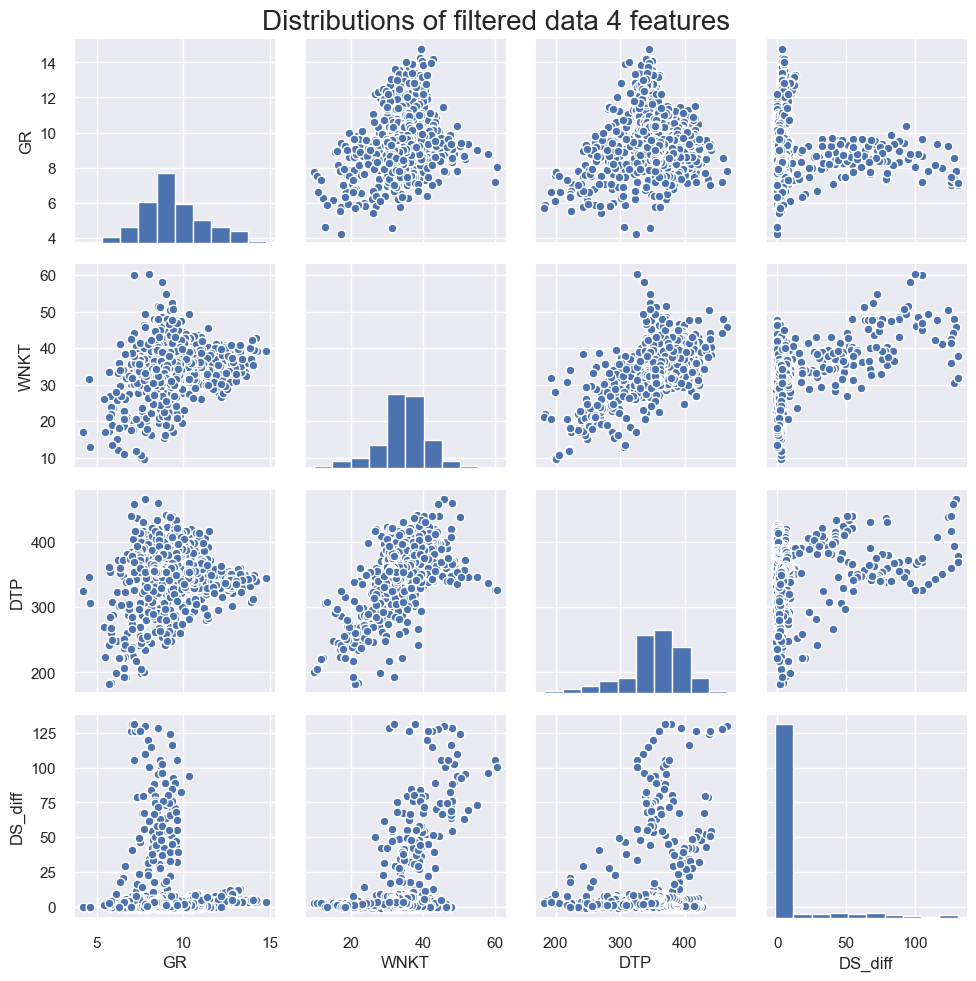

In [150]:
# Two variables distributions
# diagonal - hystogram of data distribution
def pairwise_rel(data):
    sns.set()

    # Setting pairgrid
    g = sns.PairGrid(data)

    # Populating pairgrid
    mdg = g.map_diag(plt.hist, edgecolor="w")
    mog = g.map_offdiag(plt.scatter, edgecolor="w", s=40)

    # Layout
    plt.subplots_adjust(top=0.95)
    plt.suptitle("Distributions of filtered data 4 features", fontsize=20)

    plt.show()
    
pairwise_rel(metric_df)

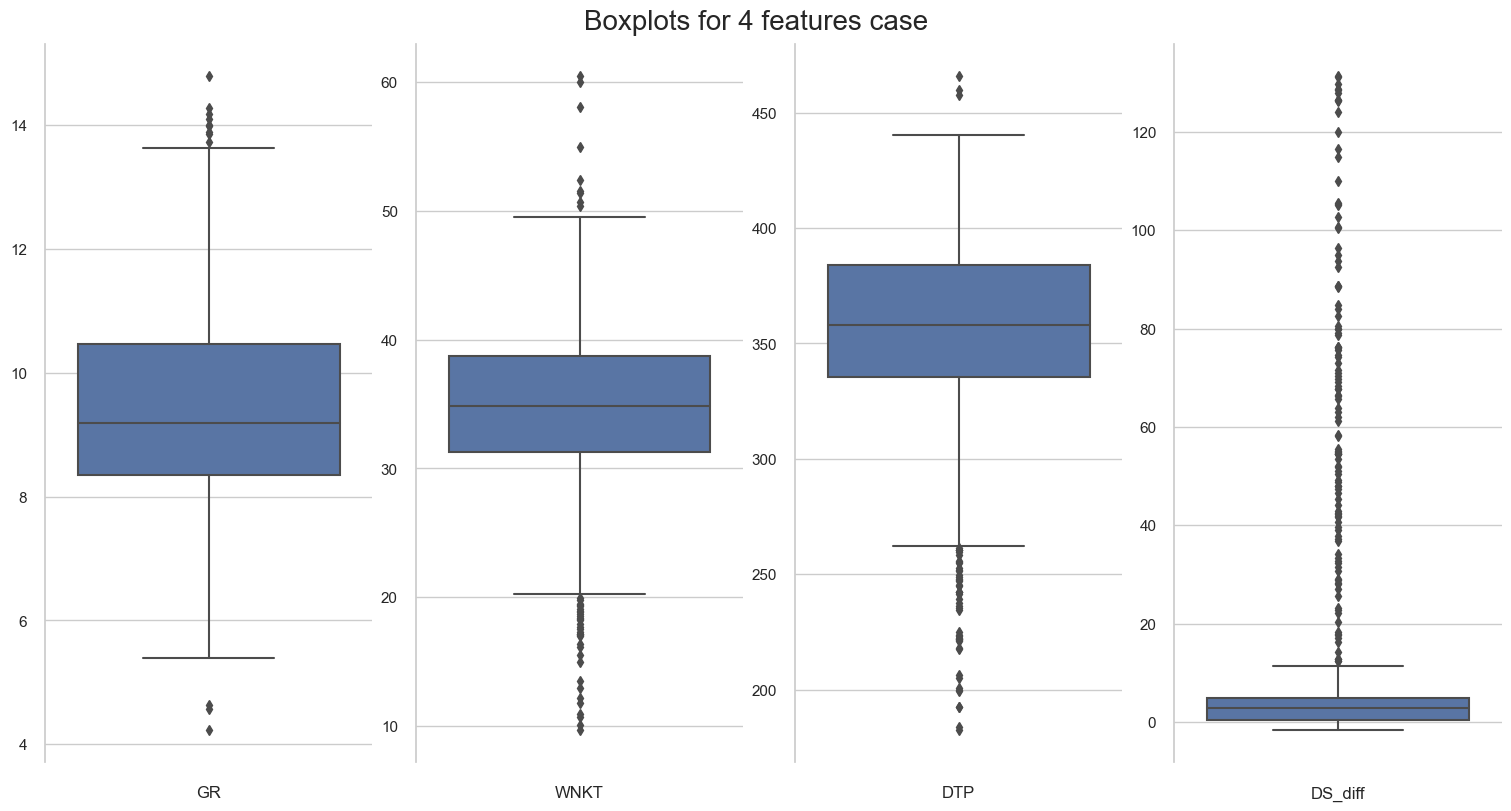

In [151]:
# box plot for visualization of univariant outliers (outliers in each variable separately)
def plot_outliers(title, data):
    sns.set(style="whitegrid")

    # Prepare dataframe layout
    plot_features = list(data.columns)

    #Prepare figure layout
    fig, axes = plt.subplots(1, len(plot_features), figsize=(15,8), constrained_layout=True)

    # Draw the boxplots
    for i in zip(axes, plot_features):
        sns.boxplot(y=i[1], data=data[[i[1]]], ax=i[0])
        i[0].set_xlabel(i[1])
        i[0].set_ylabel("")

    # Finalize the plot
    plt.suptitle(title, fontsize=20)
    sns.despine(bottom=True)

    plt.show()

plot_outliers("Boxplots for 4 features case", metric_df)

## Transformations and data preparation

In [152]:
# Using featurewise transformation to make distribution closer to Gaussian (Normal)
# two ways:
yj = PowerTransformer(method='yeo-johnson')
qt = QuantileTransformer(n_quantiles=500, output_distribution='normal', random_state=np.random.RandomState(104))

# data transformation
X_trans_yj = yj.fit_transform(metric_df)
X_trans_qt = qt.fit_transform(metric_df)

# combining data into one array
X_trans = np.concatenate((X_trans_yj, X_trans_qt), axis=1)

# one DataFrame
merge_labels = list(map(lambda x: "yj_" + x, metric_df.columns.to_list()))+list(map(lambda x: "qt_" + x,
                    metric_df.columns.to_list()))
trans_df = pd.DataFrame(X_trans, columns=merge_labels, index=metric_df.index)

In [153]:
transqt_df = trans_df.loc[:,[i for i in trans_df.columns.to_list() if "qt" in i]]
transyj_df = trans_df.loc[:,[i for i in trans_df.columns.to_list() if "yj" in i]]

In [154]:
# Outliers determination based on IQR model (interquantile range)
def out_iqr(data, k=2, return_thresholds=False):
    # IQR calculation:
    q25, q75 = np.percentile(data, 25, axis=0), np.percentile(data, 75, axis=0)
    iqr = q75 - q25
    # Cutting borders calculation
    cut_off = iqr * k
    lower, upper = q25 - cut_off, q75 + cut_off
    if return_thresholds:
        return lower, upper
    else: # identification of outliers
        return data.apply(lambda x: np.any((x<lower) | (x>upper)), 1)

outlier_labels = pd.concat([out_iqr(transyj_df, 2), out_iqr(transqt_df, 2)], axis=1)

In [155]:
# Determination of Multivariant outliers with use of Mahalanobis range
# it is base on IQR, which is applied to each column separately
# multivariant outliers - outliers on whole dataset
def out_mahalanobis(data, random, contamination=0.03):
    n = data.shape[0]
    df = data.shape[1]
    # Mahalanobis range from each sample to center and sorting by that range
    ee_out = cov.EllipticEnvelope(contamination=0.03, support_fraction=0.95, random_state=np.random.RandomState(304)).fit(data)
    mahalan = ee_out.mahalanobis(data)
    # calculate alpha-quantile (percentile) of distribution for each element
    quantiles = chi2.ppf(q=np.fromfunction(lambda x:(x-0.5)/n, (n,)), df=df)
    # labeling each element
    labels = ee_out.predict(data)
    
    return mahalan, quantiles, labels

mqt, qqt, lqt = out_mahalanobis(transqt_df, 0)
myj, qyj, lyj = out_mahalanobis(transyj_df, 0)
lqt_lyj = pd.DataFrame({'lqt': lqt, 'lyj': lyj})

In [156]:
# Share of outliers calculation
inl = lqt_lyj.loc[(lqt_lyj['lqt'] == 1) & (lqt_lyj['lyj'] == 1)].sum()['lqt']
'Share of outliers: {:4.2f}%'.format(100 - inl/len(lqt_lyj) * 100)

'Share of outliers: 4.19%'

In [157]:
# Creation of mask for outliers exclusion:
lqt_lyj.loc[(lqt_lyj['lqt'] == 1) & (lqt_lyj['lyj'] == 1), 'mask'] = True
lqt_lyj.fillna(False, inplace=True)
lqt_lyj.drop(columns=['lqt', 'lyj'], inplace=True)

In [158]:
# Mask usage
main_data = metric_df.merge(lqt_lyj, left_index=True, right_index=True)
try:
    cleaned_data = main_data.loc[main_data['mask'] == True].copy()  
except:
    print('mask was not implemented')

In [159]:
# drop mask column
cleaned_data.drop(columns=['mask'], inplace=True)

In [160]:
# number of excluded values counting
rows_after_iqr = len(cleaned_data)
print("Number of rows after clearing", rows_after_iqr)
print("Excluded samples: {} ".format(len(df) - len(cleaned_data)))

Number of rows after clearing 800
Excluded samples: 35 


In [161]:
# cleaned table
print(cleaned_data.shape)
cleaned_data.head(3)

(800, 4)


GR    WNKT      DTP  DS_diff
id                                  
0   11.988  27.955  342.777    2.887
1   11.292  29.602  345.329    2.528
2   10.933  32.643  351.024    2.514

In [162]:
# merge cleaned table with excluded data by index
clusterized = cleaned_data.merge(df[['well_id', 'TVD', 'id']], left_index=True, right_on='id')

In [163]:
# in new table we will add marks of clusters
print(clusterized.shape)
clusterized.head(3)

(800, 7)


GR    WNKT      DTP  DS_diff well_id      TVD  id
0  11.988  27.955  342.777    2.887   UZ_21  894.555   0
1  11.292  29.602  345.329    2.528   UZ_21  894.655   1
2  10.933  32.643  351.024    2.514   UZ_21  894.755   2

## Visualiation of produced data

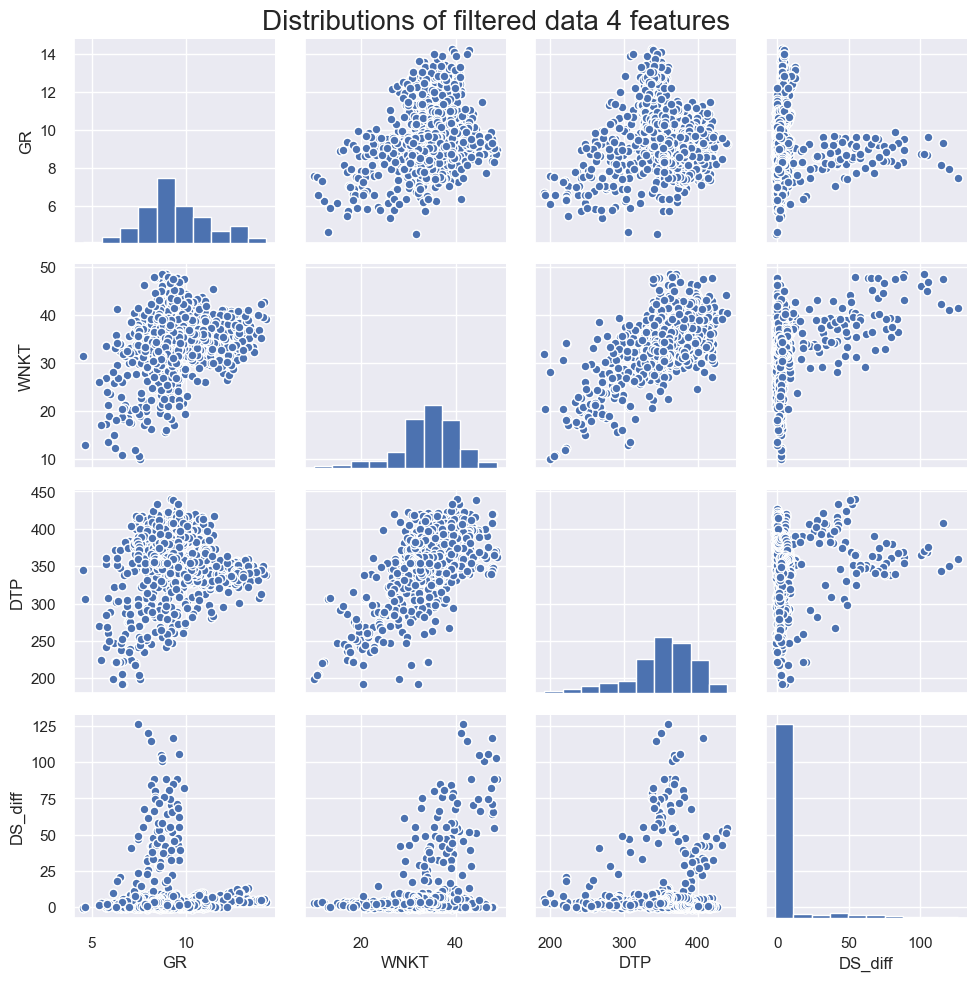

In [164]:
pairwise_rel(cleaned_data)

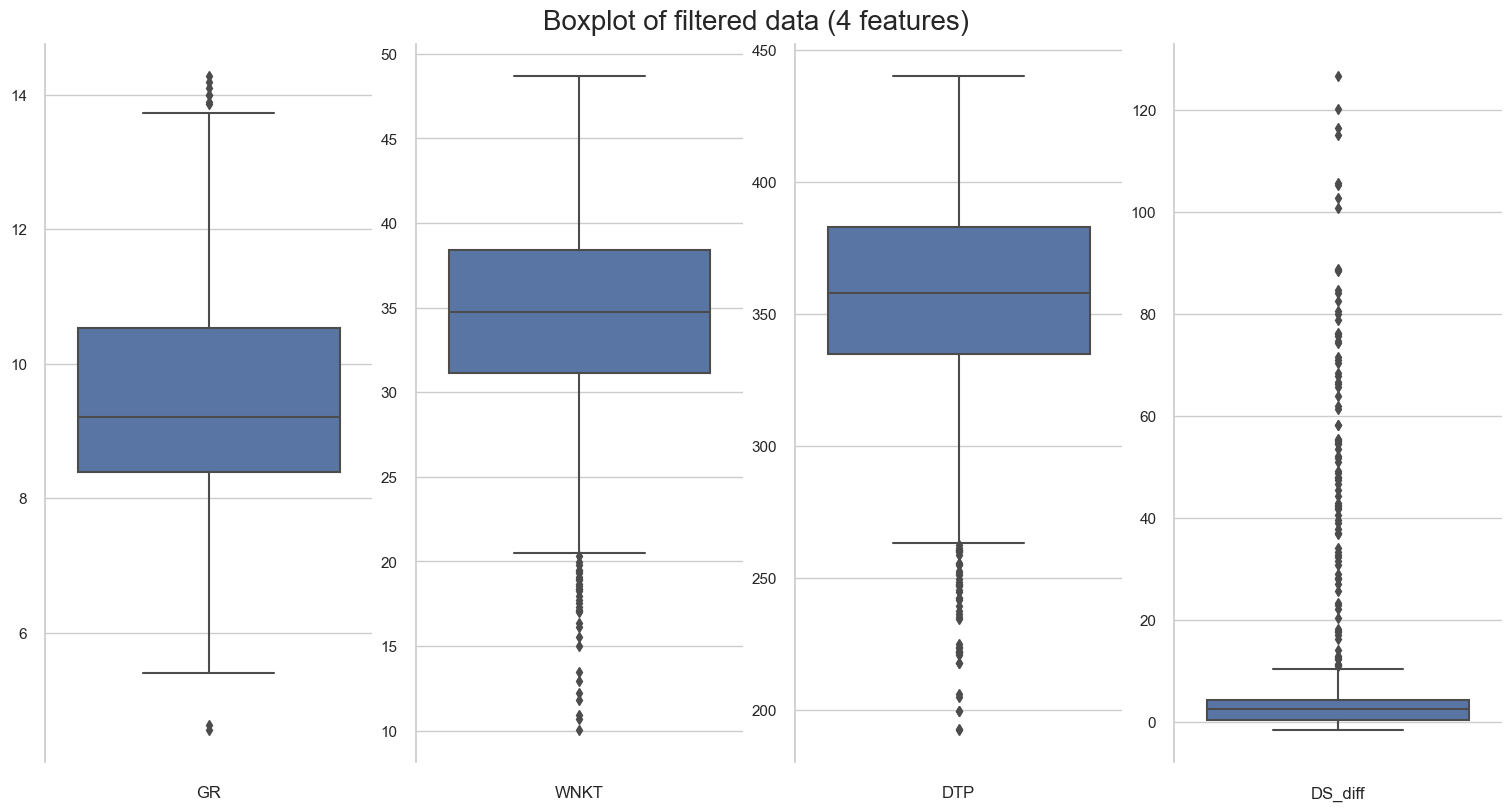

In [165]:
plot_outliers("Boxplot of filtered data (4 features)", cleaned_data)

In [166]:
# Correlation matrix function
def plot_corr_matrix(metric_df, abs_apply=False, values=False, fig_size = (7, 7)):    
    sns.set(style="white")

    # calculation of correlation matrix
    corr = metric_df.corr()
    if abs_apply == True:
        corr = corr.apply(np.abs)
    
    # mask generation for upper triangle
    mask = np.zeros_like(corr, dtype=np.bool) 
    mask[np.triu_indices_from(mask)] = True

    # matplotlib figure object
    fig, ax = plt.subplots(figsize=fig_size)

    # Color map 
    cmap = sns.diverging_palette(220, 10, as_cmap=True) #Make a diverging palette between two HUSL colors. Return a matplotlib colormap object.
        
    # HeatMap displaying and scale correction
    if values:
        mask_annot = np.absolute(corr.values)>=0.70
        annot_arr = np.where(mask_annot, corr.values.round(2), np.full(fig_size,""))
        sns.heatmap(corr, mask=mask, cmap=cmap, center=0, square=True, linewidths=.5, ax=ax, annot=annot_arr, fmt="s")
    else:
        sns.heatmap(corr, mask=mask, cmap=cmap, center=0, square=True, linewidths=.5, ax=ax)

    # plotting
    plt.subplots_adjust(top=0.95)
    plt.suptitle("Correlation matrix initial data", fontsize=20)
    plt.yticks(rotation=0)
    b, t = plt.ylim()
    b += 0.5
    t -= 0.5
    plt.ylim(b, t)

    plt.show()

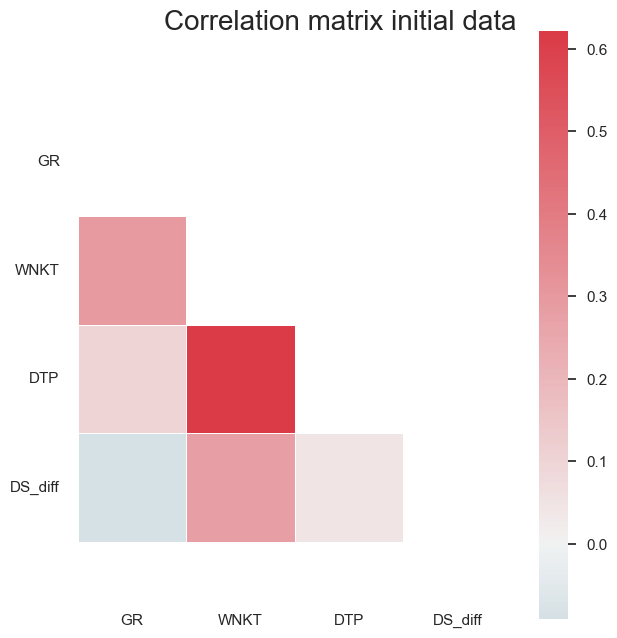

In [167]:
plot_corr_matrix(cleaned_data)

# Clustering

## Preparation

In [168]:
# K-elbowplot method for number of clusters determination
def kelbowplots(clus_estim, data):
    """
    Method shows 3 metrics: "Distortion", "Silhouette" and "Calinski Harabasz"
    for different number of clusters with use of specified clustering model (clust_estim)
    """
    sns.set()
    fig, axes = plt.subplots(1, 3, figsize=(20,7))

    metrics = ["distortion", "silhouette", "calinski_harabasz"]
    ylabels = ["Risk of distortion", "Silhouette coefficient", "Calinski Harabasz criteria"]
    titles = ["Distortion", "Silhouette score", "Calinski Harabasz"]
    for ax, m, yl, tl in zip(axes.flatten(), metrics, ylabels, titles):
        KElbowVisualizer(clus_estim, metric=m, timings=False, locate_elbow=False, ax=ax).fit(data)
        #ax.invert_xaxis()
        ax.set_ylabel(yl, fontsize=13)
        ax.set_xlabel("Number of clusters", fontsize=13)
        ax.set_title(tl, fontsize=13)

    plt.suptitle("K-Elbow graphs", fontsize=20)

    plt.show()

In [169]:
def comp_gmm_models(df, max_nclus, min_nclus=2):
    """
    Bar plot for (AIC, BIC) metrics to determine desirable GMM model configuration
    """
    # Data
    n_components_range = range(min_nclus, max_nclus+1)
    cv_types = ['spherical', 'tied', 'diag', 'full']  # values type covariation
    bic = np.empty((4, len(n_components_range)))
    aic = np.empty((4, len(n_components_range)))
    for r, cv_type in enumerate(cv_types):
        for c, n_components in enumerate(n_components_range):
            # GM model for different types of EM covariation
            gmm = GaussianMixture(n_components=n_components, covariance_type=cv_type)
            gmm.fit(df)
            # save values of criterias
            bic[r, c] = gmm.bic(df)
            aic[r, c] = gmm.aic(df)
    
    # plotting bar plots
    bic = pd.DataFrame(bic, columns=n_components_range, index=cv_types)
    aic = pd.DataFrame(aic, columns=n_components_range, index=cv_types)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(23,7))
    
    sns.barplot(data=bic.reset_index().melt(id_vars="index"),
                x="variable", y="value", hue="index", ax=ax1)
    
    sns.barplot(data=aic.reset_index().melt(id_vars="index"),
                x="variable", y="value", hue="index", ax=ax2)

    # определение параметров визуализации
    ax1.set_xlabel('Number of components')
    ax2.set_xlabel('Number of components')
    ax1.set_ylabel('BIC')
    ax2.set_ylabel('AIC')
    ax1.legend(title="Covariation type")
    ax2.legend(title="Covariation type")
    plt.suptitle('BIC and AIC for models', fontsize=23)

    plt.show()

In [170]:
def silhouette_analysis(df, estimator, shape, figsize, max_nclus, min_nclus=2, dist="euclidean"):
    """
    Function calculates Silouette coefficient for each sample and buildes Graph
    Can be used for bets number of clusters determination
    """
    range_n_clusters = list(range(min_nclus, max_nclus+1))
    
    sns.set()
    fig, axes = plt.subplots(nrows=shape[0], ncols=shape[1], figsize=figsize)
    if len(range_n_clusters)==1: # if we need to build plot for only 1 cluster
        forax = [axes]
    else:
        forax = axes.flatten()
    for ax, n_clusters in zip(forax, range_n_clusters):
        
        if "n_clusters" in estimator.get_params():
            param = "n_clusters"
        elif "n_components" in estimator.get_params():
            param = "n_components"
        else:
            print("Model does not have parameter for number of clusters determination")
            return None
        
        # producing clusters marks
        clustering = estimator.set_params(**{param:n_clusters})
        labels = clustering.fit_predict(df)
        
        # Silhouette_score gives average value for all sample
        # this gives us knowledge about distribution and density of produced clusters
        silhouette_avg = silhouette_score(df, labels, metric=dist)
        
        # Calculation of Silhouette score for each sample
        sample_silhouette_values = silhouette_samples(df, labels, metric=dist)
        
        # silhouette coefficient [-1; 1]
        ax.set_xlim([sample_silhouette_values.min()-0.1, 1])
        # Separation between clusters
        ax.set_ylim([0, df.shape[0] + (n_clusters + 1) * 10]) 
        
        y_lower = 10 # y_lower initialization
        for i in range(n_clusters):
            # silhouette scores aggregation for samples from same cluster
            # and then sorting samples inside clusters
            ith_cluster_silhouette_values = sample_silhouette_values[labels == i]

            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_clusters)
            ax.fill_betweenx(np.arange(y_lower, y_upper),
                              0, ith_cluster_silhouette_values,
                              facecolor=color, edgecolor=color, alpha=0.7)

            # Marks on each cluster
            ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # calculation of new y_lower for new graph
            y_lower = y_upper + 10  # 10 for zero samples
        
        ax.set_title("{} clusters".format(n_clusters), fontsize=13)
        ax.set_xlabel("Silhouette coefficient")
        ax.set_ylabel("Cluster labels")
        ax.set_yticks([])  # Drop of marks on y axis
        ax.axvline(x=silhouette_avg, color="red", linestyle="--", label="Average Silhouette coefficient") # vertical line, for average Score
        handles, _ = ax.get_legend_handles_labels()
        ax.legend(handles, ["Average coefficient = {0:.4f}".format(silhouette_avg)])
    
    plt.subplots_adjust(hspace=0.35)
    plt.suptitle(("Profiles of clusters for different number of clusters"), fontsize=23, fontweight='bold')
    plt.show()

In [171]:
def get_r2_hc(df, link, max_nclus, min_nclus=1, dist="euclidean"):
    """
    Function calculates R2 matric for clusters, based on Hierarchical clustering.
    R2 - measure of homogeneity inside cluster. Sum of squares (SSt) for all data
    can be separated on Sum (SS) in clusters (SSw) and SS between clusters (SSb): SSt = SSw + SSb.
    R2 - is relation between SSb and SSt: R2 = SSb / SSt.
    The higher R2 the better clustering is produced, since SSw will be close to 0,
    which shows that homogeneity is ideal inside clusters.
    """
    def get_ss(matrix):
        mc = matrix - matrix.mean(axis=0)
        return (mc.T@mc).trace() # sum of squares in matrix
    
    matrix = df.values
    ncols = matrix.shape[1]
    sst = get_ss(matrix) # whole sum of squares
    
    r2 = np.array([]) # R2 metrics array
    
    for i in range(min_nclus, max_nclus+1):
        Hclustering = AgglomerativeClustering(n_clusters=i, affinity=dist, linkage=link)
        hclabels = Hclustering.fit_predict(matrix) # get cluster labels
        concat = np.concatenate((matrix, np.expand_dims(hclabels,1)), axis=1)
        ssw = np.array([get_ss(concat[concat[:,ncols]==j, :ncols]) for j in range(i)]).sum() # calculation of SSw metrics for specified model
        r2 = np.append(r2, (sst-ssw)/sst)
        
    return r2

In [172]:
def cluster_profiles(df, label_columns, figsize, compar_titles=None):
    """
    Plotting parallel plot for average values of variables in each cluster
    Histogram of number of samples in produced clusters
    """
    if compar_titles == None:
        compar_titles = [""]*len(label_columns)
        
    sns.set()
    fig, axes = plt.subplots(nrows=len(label_columns), ncols=2, figsize=figsize, squeeze=False)
    for ax, label, titl in zip(axes, label_columns, compar_titles):
        # filtering
        drop_cols = [i for i in label_columns if i!=label]
        dfax = df.drop(drop_cols, axis=1)
        
        # determination og centoids and number of elements in cluster
        centroids = dfax.groupby(by=label, as_index=False).mean()
        counts = dfax.groupby(by=label, as_index=False).count().iloc[:,[0,1]]
        counts.columns = [label, "counts"]
        
        # plotting
        pd.plotting.parallel_coordinates(centroids, label, color=sns.color_palette(), ax=ax[0])
        sns.barplot(x=label, y="counts", data=counts, ax=ax[1])

        handles, _ = ax[0].get_legend_handles_labels()
        cluster_labels = ["Number of cluster - {}".format(i) for i in range(len(handles))]
        ax[0].annotate(text=titl, xy=(0.95,1.1), xycoords='axes fraction', fontsize=13, fontweight = 'heavy') 
        ax[0].legend(handles, cluster_labels) # setting for number of clusters
        ax[0].axhline(color="black", linestyle="--")
        ax[0].set_title("Average of clusters - {} ".format(len(handles)), fontsize=13)
        ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=-20)
        ax[1].set_xticklabels(cluster_labels)
        ax[1].set_xlabel("")
        ax[1].set_ylabel("Absolute frequency")
        ax[1].set_title("Size of clusters - {}".format(len(handles)), fontsize=13)
    
    plt.subplots_adjust(hspace=0.4, top=0.90)
    plt.suptitle("Clusters profile", fontsize=23)
    plt.show()

In [173]:
# scaling all parameters to ensure equal importance
scaler = StandardScaler()
std_df = pd.DataFrame(scaler.fit_transform(cleaned_data), index=cleaned_data.index, columns=cleaned_data.columns)

## K-Means model

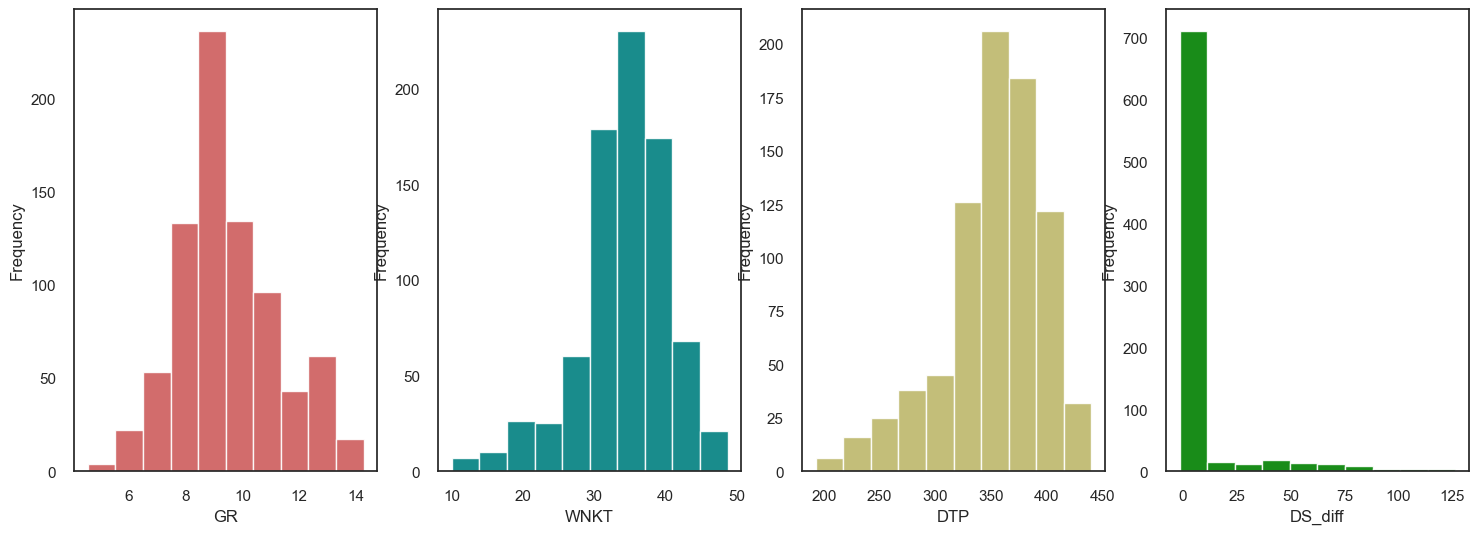

In [174]:
# distribution of measurements
fig, axes = plt.subplots(1, 4, figsize=(18,6))
for col, ax, color in zip(cleaned_data, axes, ['indianred', 'teal', 'darkkhaki', 'green']):
    cleaned_data[col].plot.hist(ax=ax, alpha=0.9, color=color, ylabel='Frequency')
    ax.set_xlabel(col)
plt.show()

### Looking for proper number of clusters

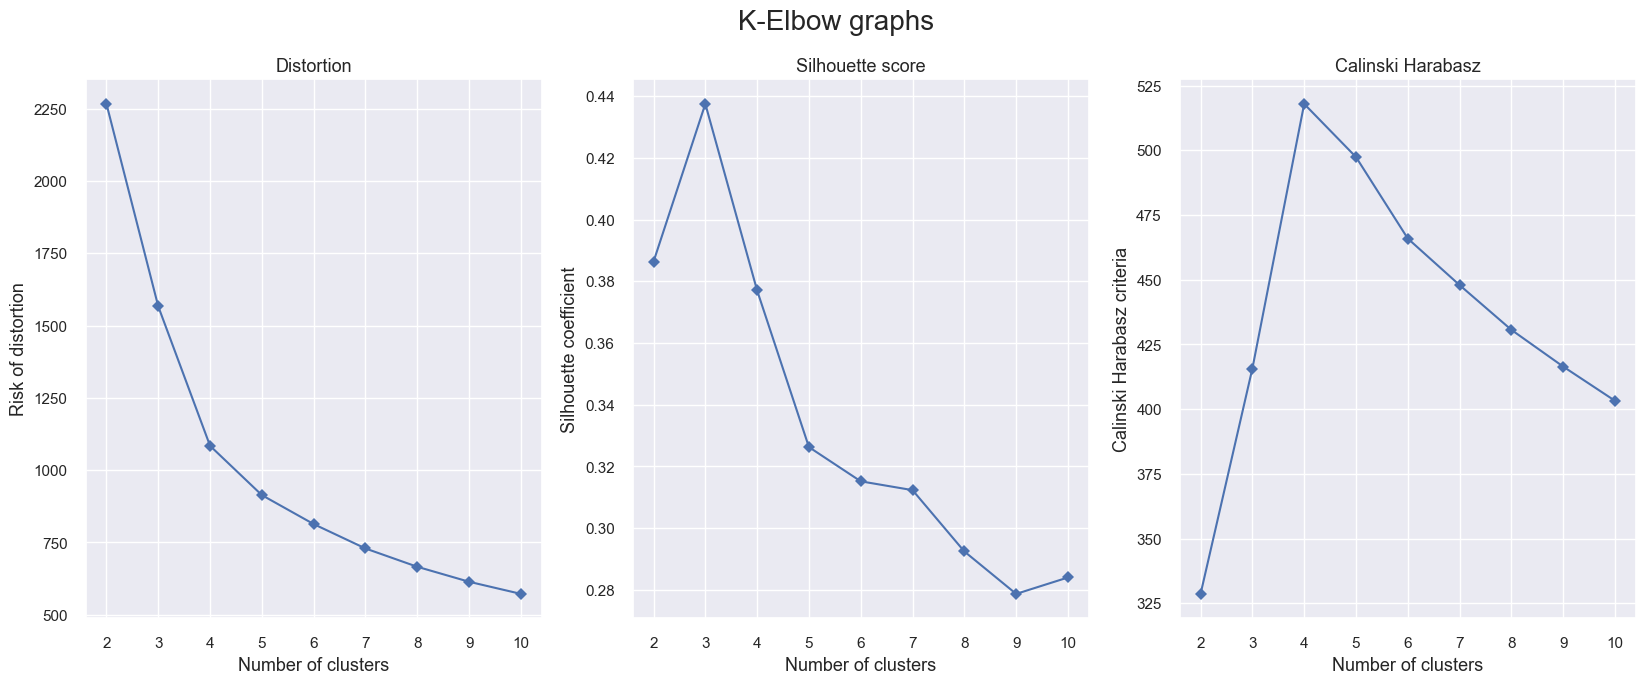

In [175]:
# K-Means model initialization
clus_estim = KMeans(random_state=0)

# K-elbow method
kelbowplots(clus_estim, std_df)

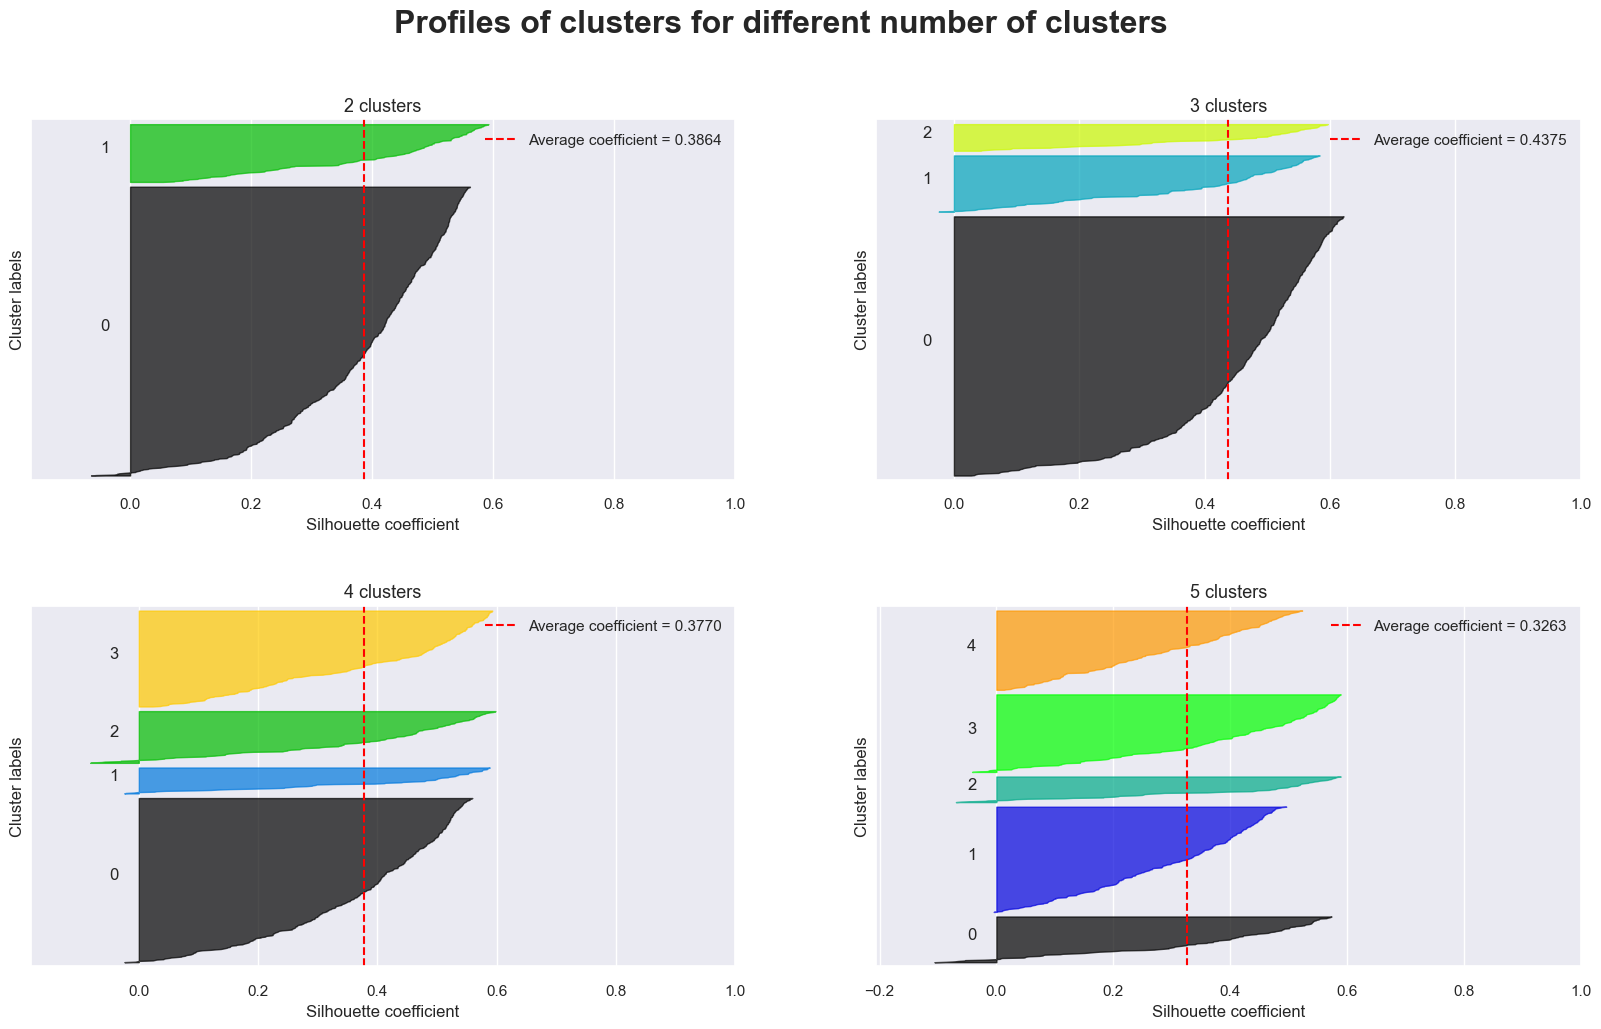

In [176]:
silhouette_analysis(std_df, clus_estim, (2,2), (20, 11), 5)

In [177]:
# clustering with K-Means
def make_clusters(n_clusters):
    kmeans = KMeans(init='k-means++', n_clusters=n_clusters)
    df_res = std_df.copy()
    df_res['cluster'] = kmeans.fit_predict(np.array(std_df))
    return df_res

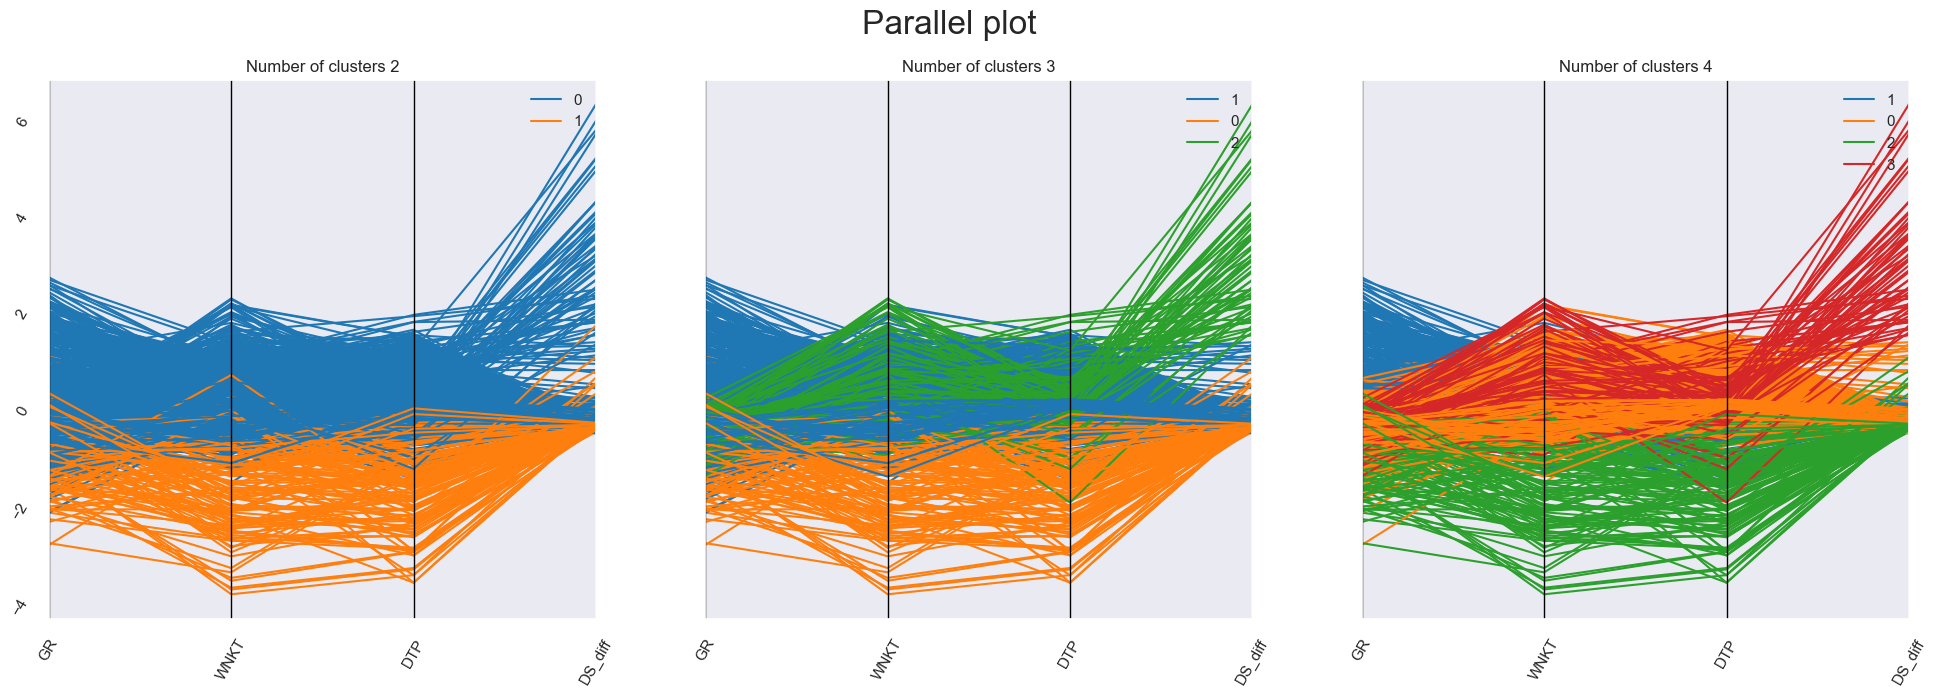

In [178]:
# parallel plot for different number of clusters
f, axs = plt.subplots(1, 3, sharey=True, sharex=True, figsize=(24, 7))
for i, ax in zip(range(2, 5), axs.flatten()):
    df_res = make_clusters(i)
    pd.plotting.parallel_coordinates(df_res, 'cluster', color=list(mcolors.TABLEAU_COLORS.values()), ax=ax)
    ax.tick_params(labelrotation=60)
    ax.set_title('Number of clusters ' + str(i))

plt.suptitle("Parallel plot", fontsize=24)
plt.show()

### Clustering

In [179]:
#K means clustering
def doKMeans(df, nclust):
    model = KMeans(nclust, random_state=0)
    model.fit(df)
    clust_labels = model.predict(df)
    cent = model.cluster_centers_
    return clust_labels, cent

clusters, cent = doKMeans(std_df, 4)
clusterized['kmeans_labels']= clusters

### Visualization of clustering

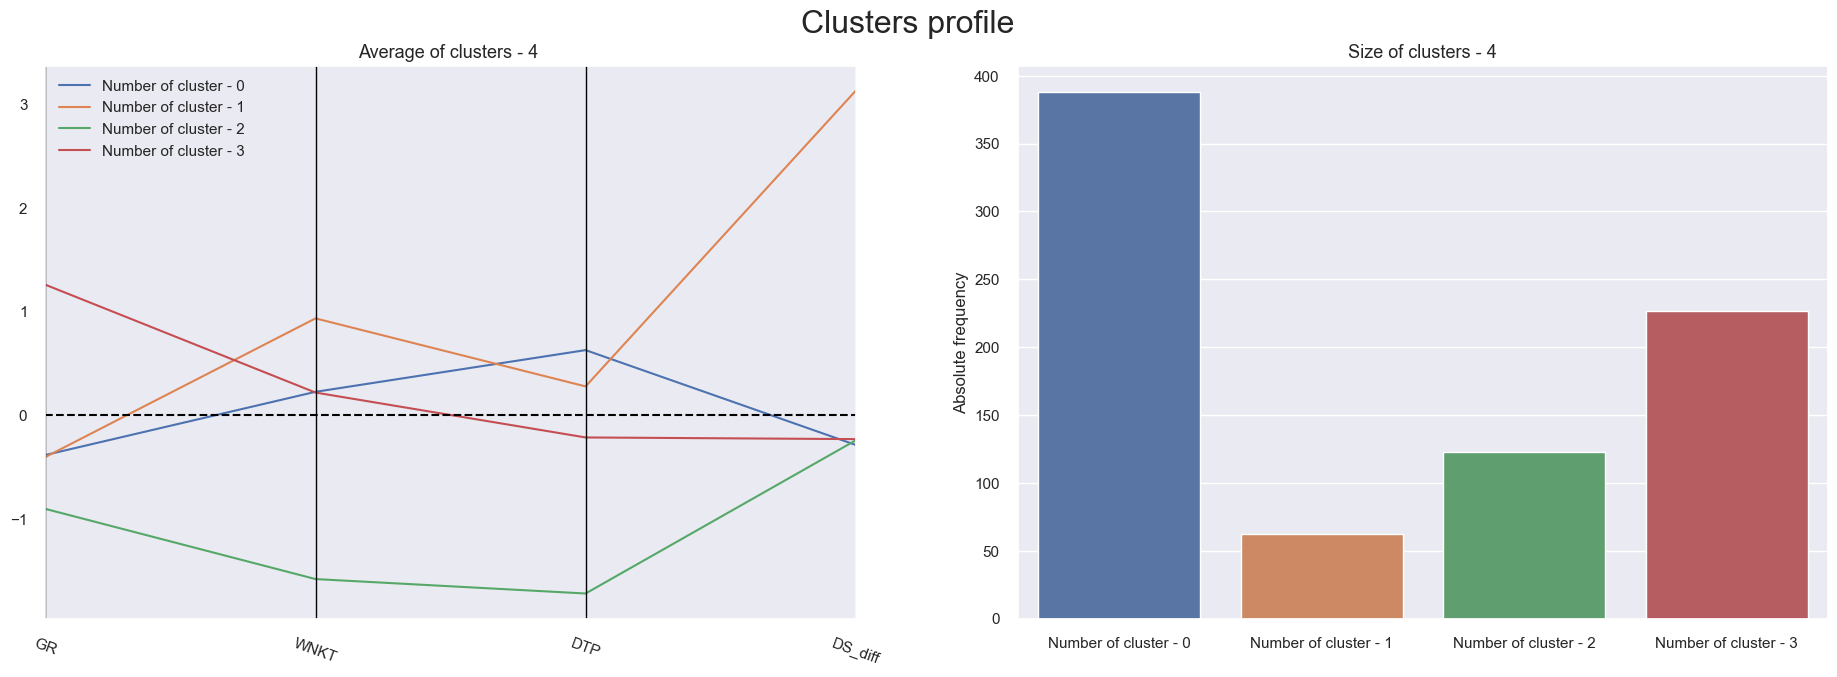

In [180]:
kmeans_std_df = std_df.copy()
kmeans_std_df['clusters'] = list(clusterized['kmeans_labels'])
cluster_profiles(kmeans_std_df, ["clusters"], (23, 7))

In [181]:
newcolors = ['blue','orange','green', 'red' ]
newcmp = ListedColormap(newcolors)

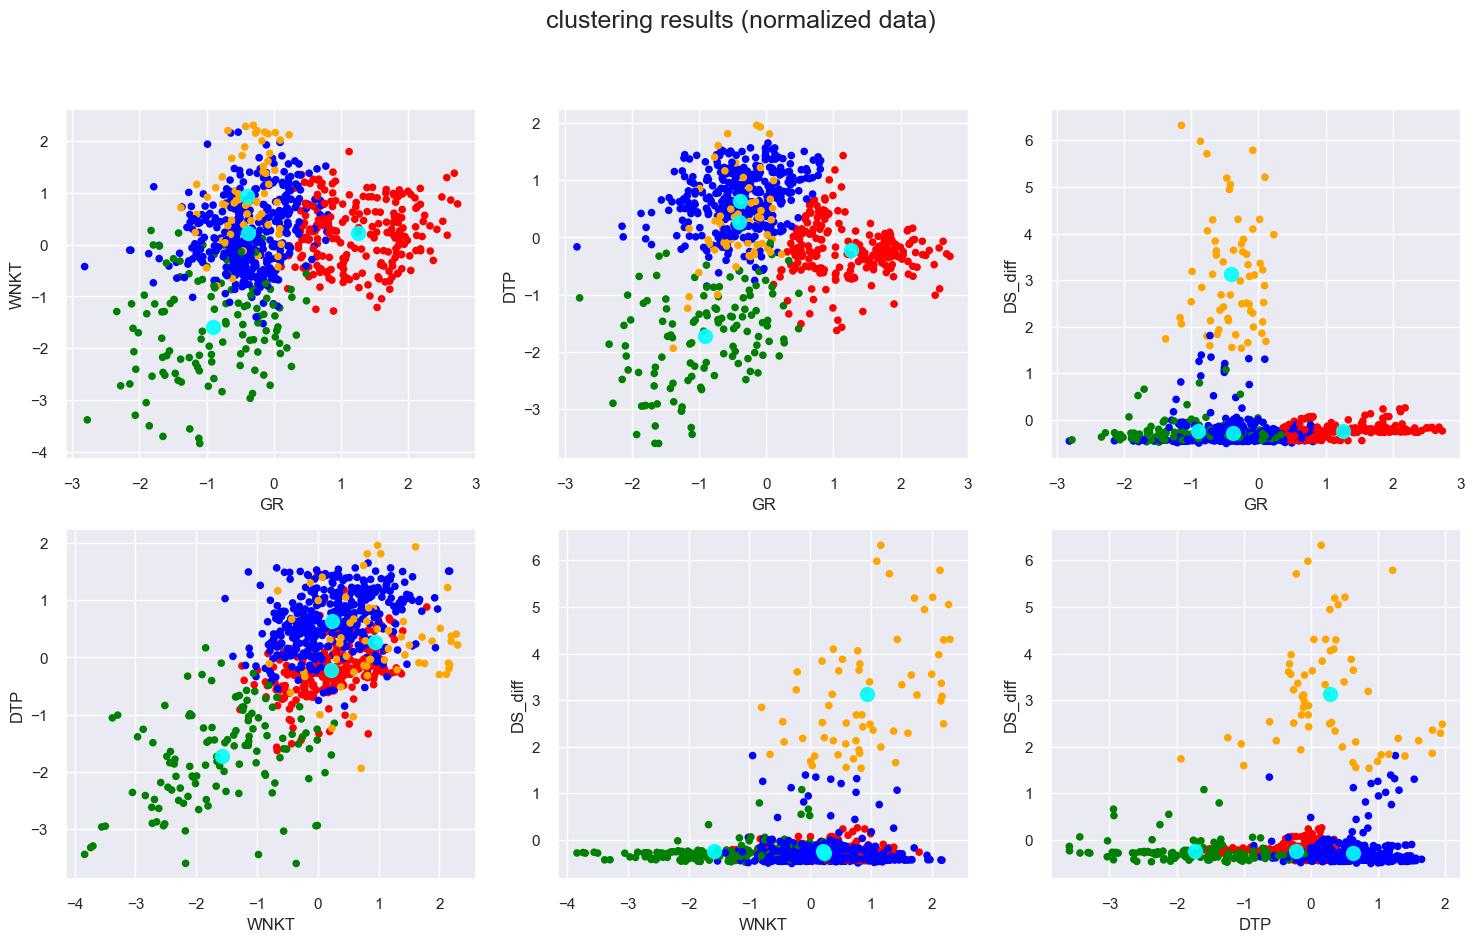

In [182]:
# scatter plot for produced clustering (normalized data)
pairs = combinations(std_df, 2)

fig, axes = plt.subplots(2, 3, figsize=(18,10))
for ax, var_pair in zip(axes.flatten(), pairs):
    ax.scatter(std_df[var_pair[0]], std_df[var_pair[1]], c = clusterized['kmeans_labels'], s = 20, cmap = newcmp)
    ax.scatter(cent.T[list(std_df.columns).index(var_pair[0])], cent.T[list(std_df.columns).index(var_pair[1])],
               c = 'cyan', s = 100, alpha = 0.9)
    ax.set_xlabel(var_pair[0])
    ax.set_ylabel(var_pair[1])
plt.suptitle('clustering results (normalized data)', fontsize=18)
plt.show()

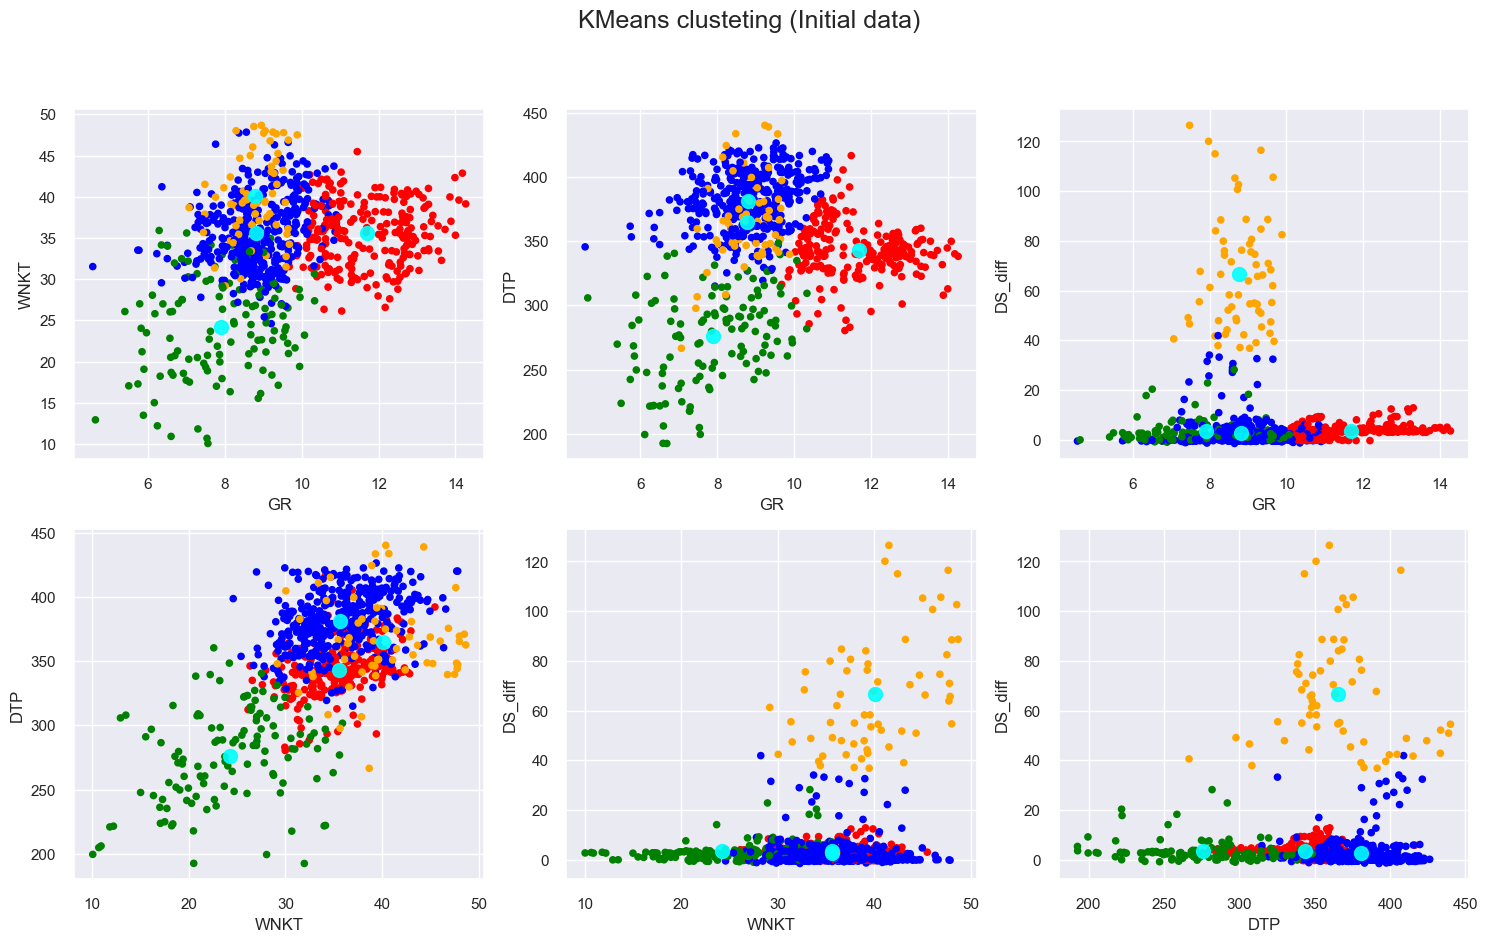

In [183]:
# scatter plot for produced clustering (initial data)
pairs = combinations(clusterized[std_df.columns], 2)
original_centroids = scaler.inverse_transform(cent)

fig, axes = plt.subplots(2, 3, figsize=(18,10))
for ax, var_pair in zip(axes.flatten(), pairs):
    ax.scatter(clusterized[std_df.columns][var_pair[0]], clusterized[std_df.columns][var_pair[1]],
               c = clusterized['kmeans_labels'], s = 20, cmap = newcmp)
    ax.scatter(original_centroids.T[list(std_df.columns).index(var_pair[0])],
               original_centroids.T[list(std_df.columns).index(var_pair[1])],
              c = 'cyan', s = 100, alpha = 0.9)
    ax.set_xlabel(var_pair[0])
    ax.set_ylabel(var_pair[1])
plt.suptitle('KMeans clusteting (Initial data)', fontsize=18)
plt.show()

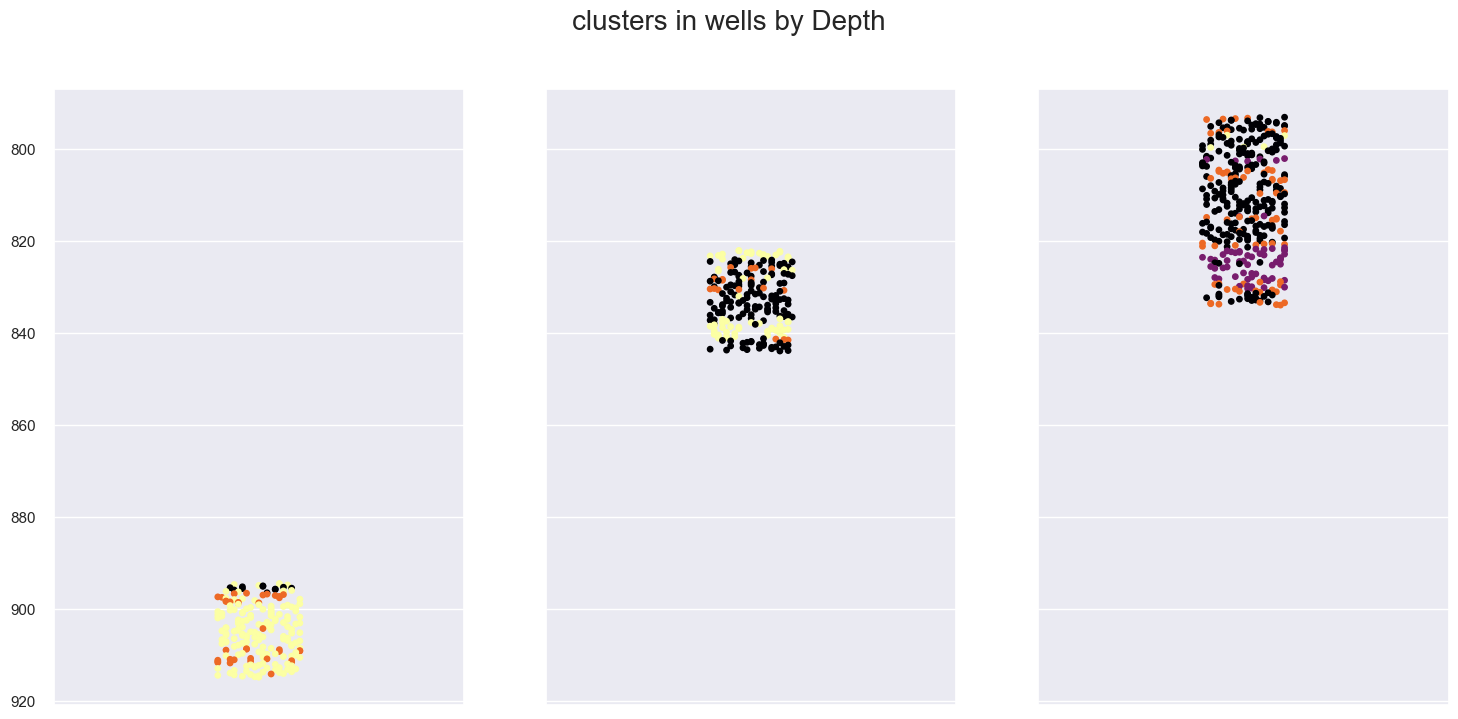

In [184]:
# displaying in wells view

# k - width parameter (part of X axis length)
k = 0.2

n_plots = clusterized.well_id.nunique()
n_rows = int(np.ceil(n_plots / 3))

fig, axes = plt.subplots(n_rows, 3, figsize=(18, 8 * n_rows), sharey=True)
for well, ax in zip(clusterized.well_id.unique(), axes.flatten()):
    df_well = clusterized.loc[clusterized.well_id == well].copy()
    df_well['x_coord'] = 1
    df_well.x_coord = df_well['x_coord'].apply(lambda x: x * randint(int(50 - 100 * k/2), int(50 + 100 * k/2)) / 100)
    ax.scatter(df_well.x_coord, df_well.TVD, c=df_well['kmeans_labels'], s=15, cmap='inferno')
    ax.set_xlim([0, 1])
    ax.invert_yaxis()
    ax.set_xticks([])
plt.suptitle('clusters in wells by Depth', fontsize=20)
plt.show()

## Gaussian Mixture Model (GMM)

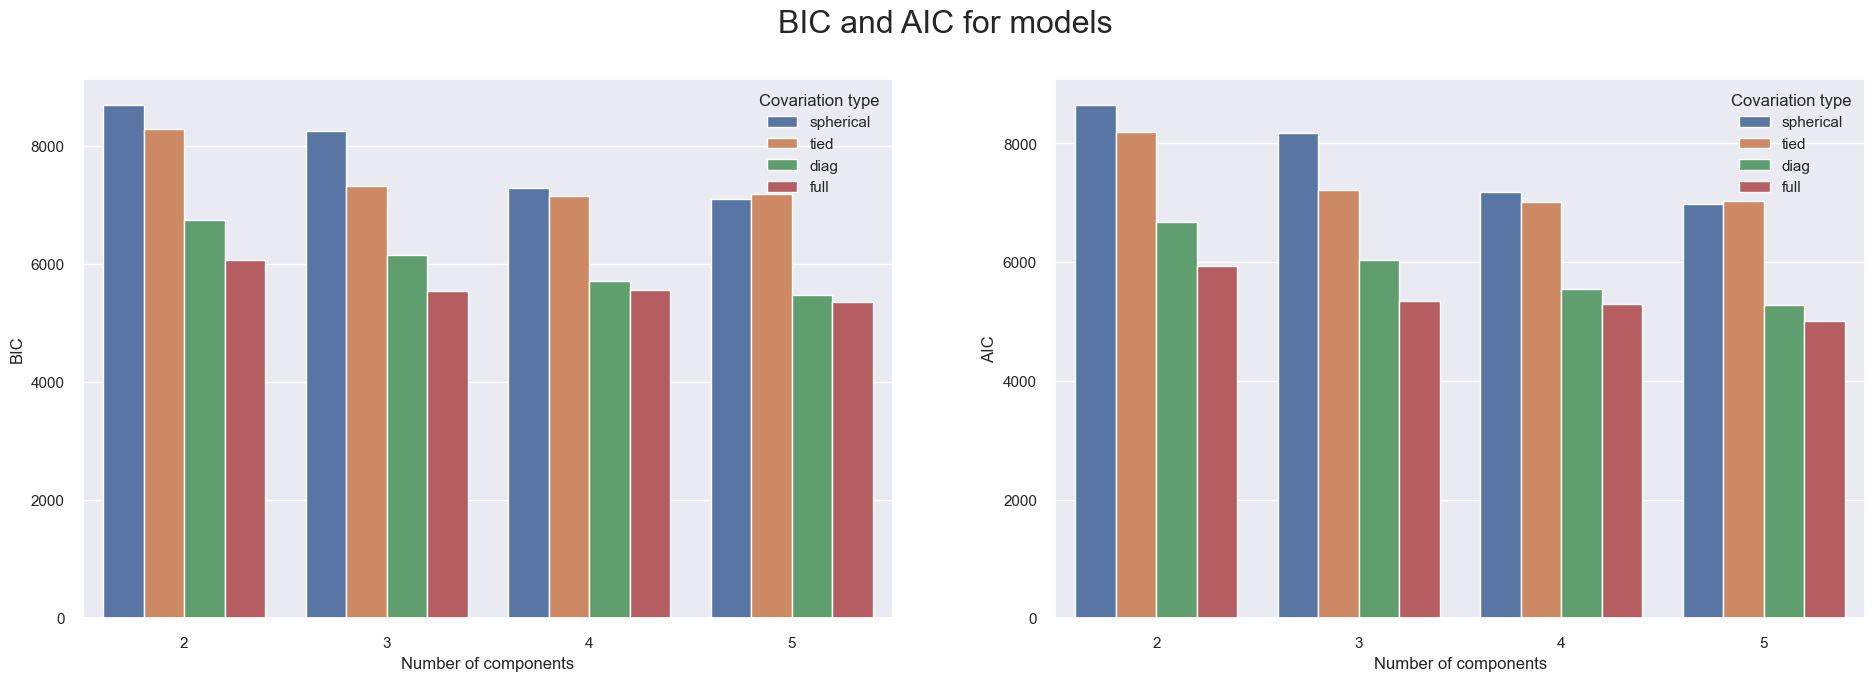

In [185]:
comp_gmm_models(std_df, 5)

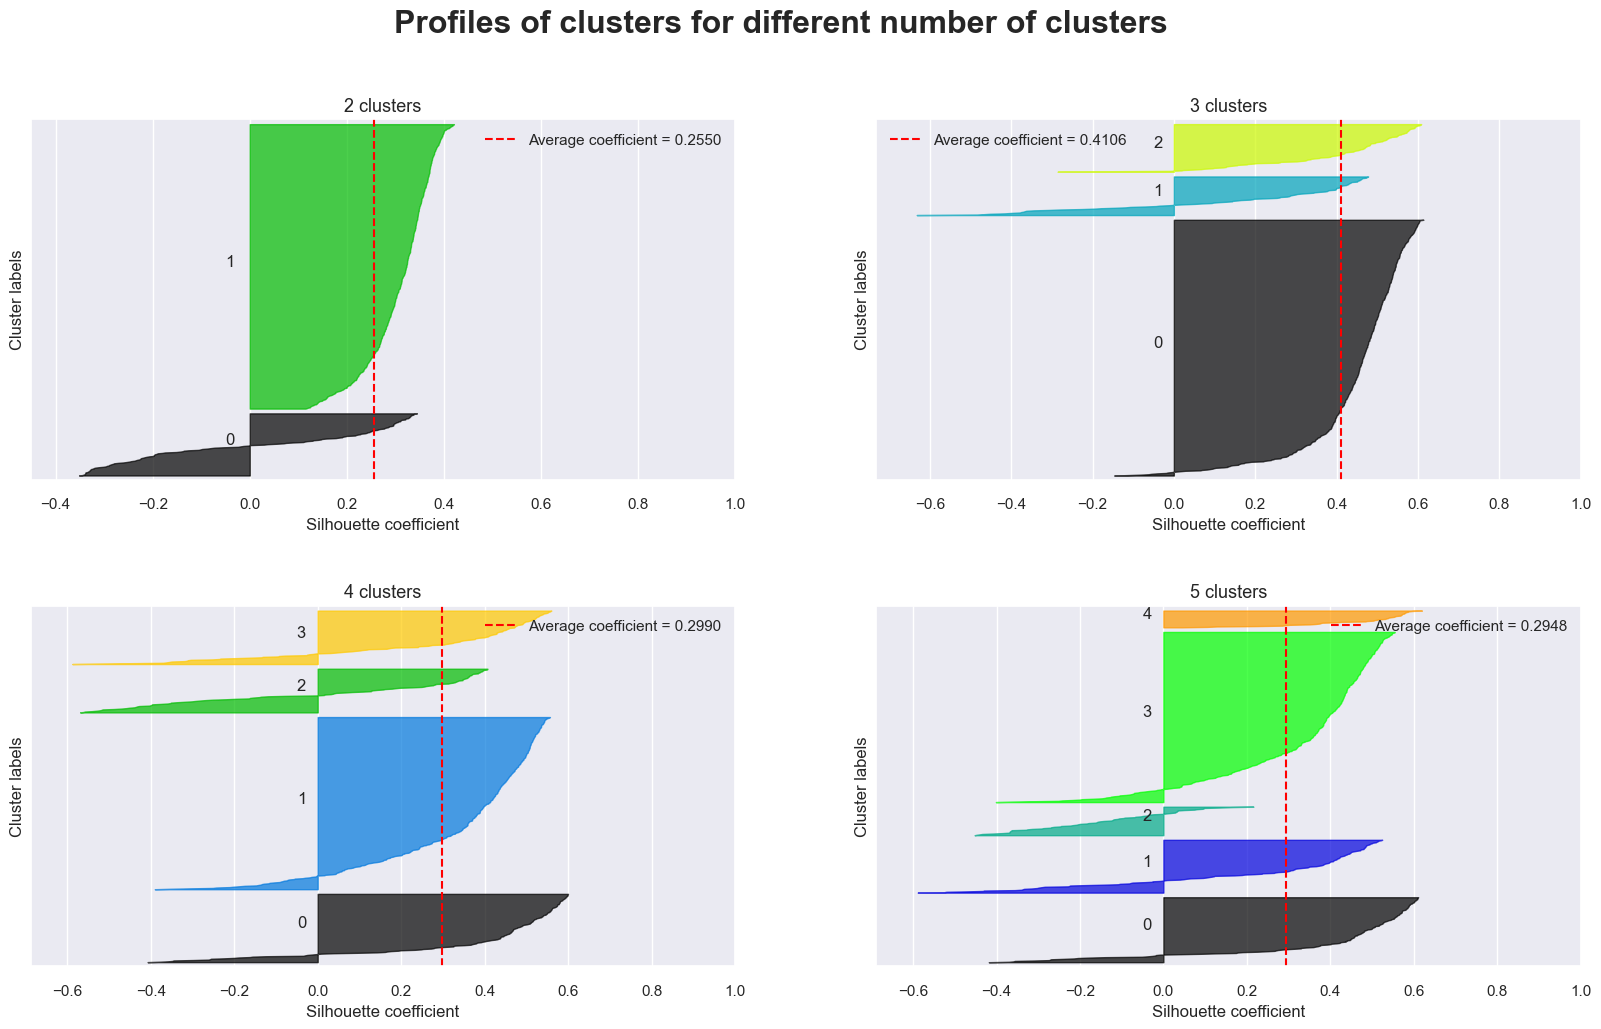

In [186]:
estimator = GaussianMixture()
silhouette_analysis(std_df, estimator, (2,2), (20, 11), 5)

### Clustering

In [187]:
def make_clusters_gmm(df, nclust):
    model=GaussianMixture(n_components=nclust, init_params='kmeans', random_state=0)
    model.fit(df)
    clust_labels = model.predict(df)
    return(clust_labels)

In [188]:
clusterized["gmm_labels"] = make_clusters_gmm(std_df, 4)

### Analysis and Visualization

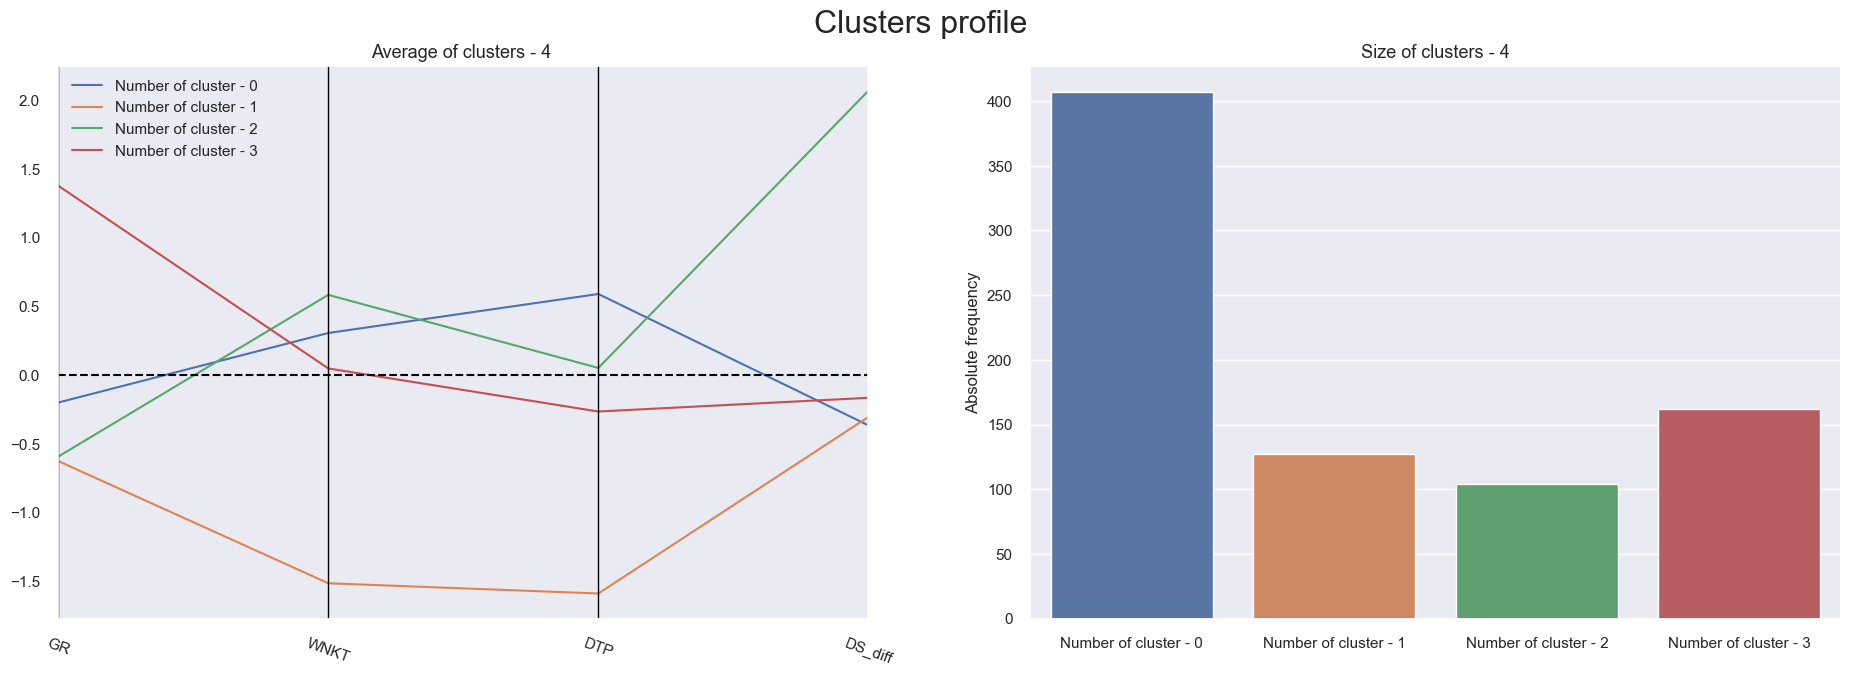

In [189]:
gmm_std_df = std_df.copy()
gmm_std_df['clusters'] = list(clusterized['gmm_labels'])
cluster_profiles(gmm_std_df, ["clusters"], (23, 7))

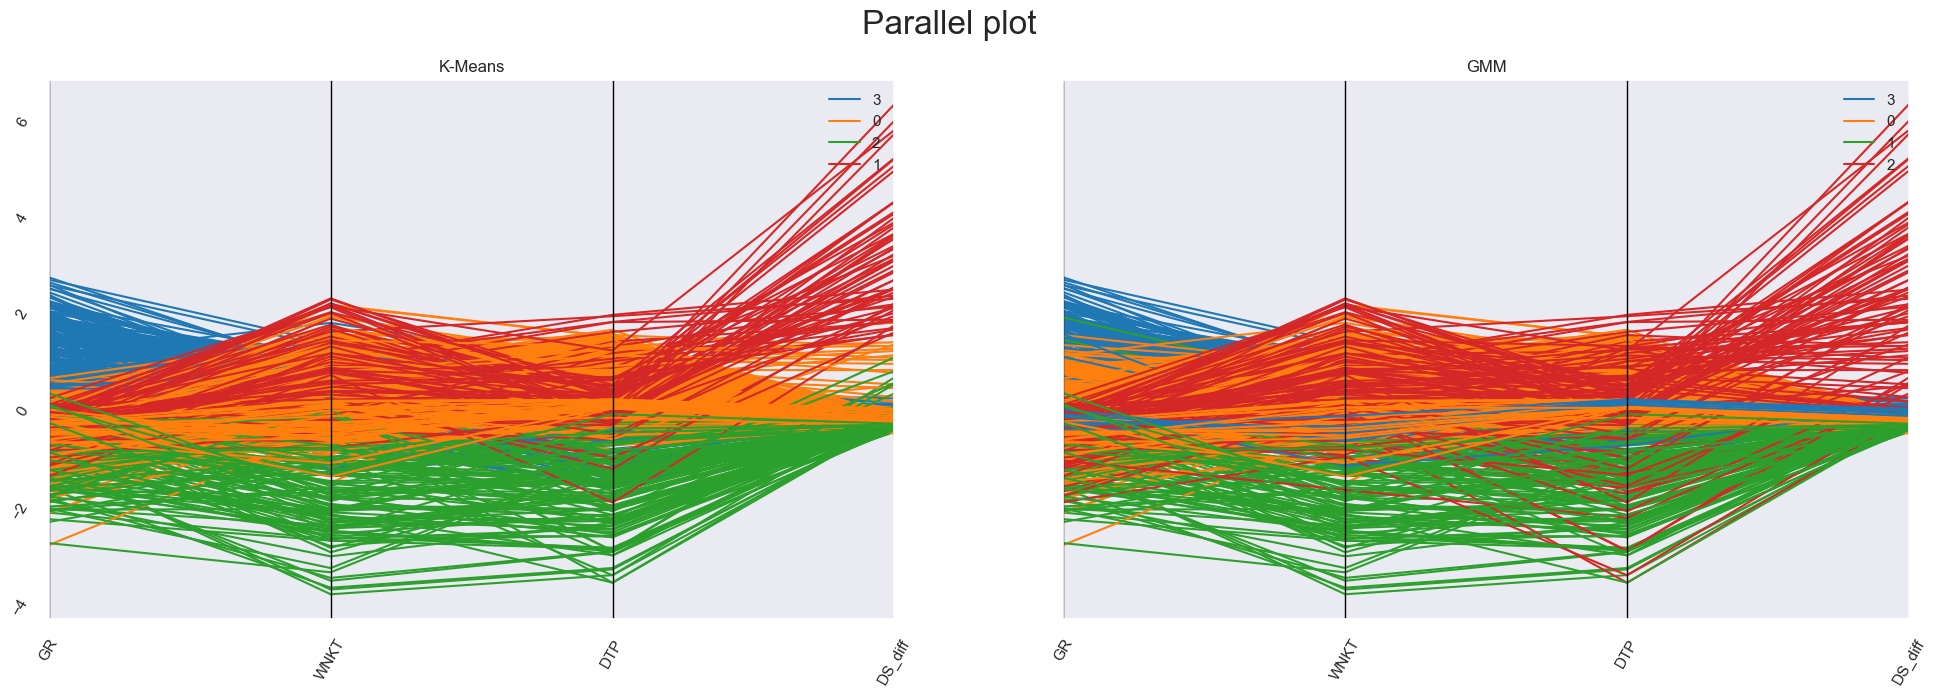

In [190]:
# comparison on parallel plot between K-Means and GMM
f, axs = plt.subplots(1, 2, sharey=True, sharex=True, figsize=(24, 7))
std_df_kmeans = std_df.copy()
std_df_kmeans['labels'] = list(clusterized.kmeans_labels)
std_df_gmm = std_df.copy()
std_df_gmm['labels'] = list(clusterized.gmm_labels)
pd.plotting.parallel_coordinates(std_df_kmeans, 'labels', color=list(mcolors.TABLEAU_COLORS.values()), ax=axs[0])
pd.plotting.parallel_coordinates(std_df_gmm, 'labels', color=list(mcolors.TABLEAU_COLORS.values()), ax=axs[1])
axs[0].tick_params(labelrotation=60)
axs[1].tick_params(labelrotation=60)
axs[0].set_title('K-Means')
axs[1].set_title('GMM')

plt.suptitle("Parallel plot", fontsize=24)
plt.show()

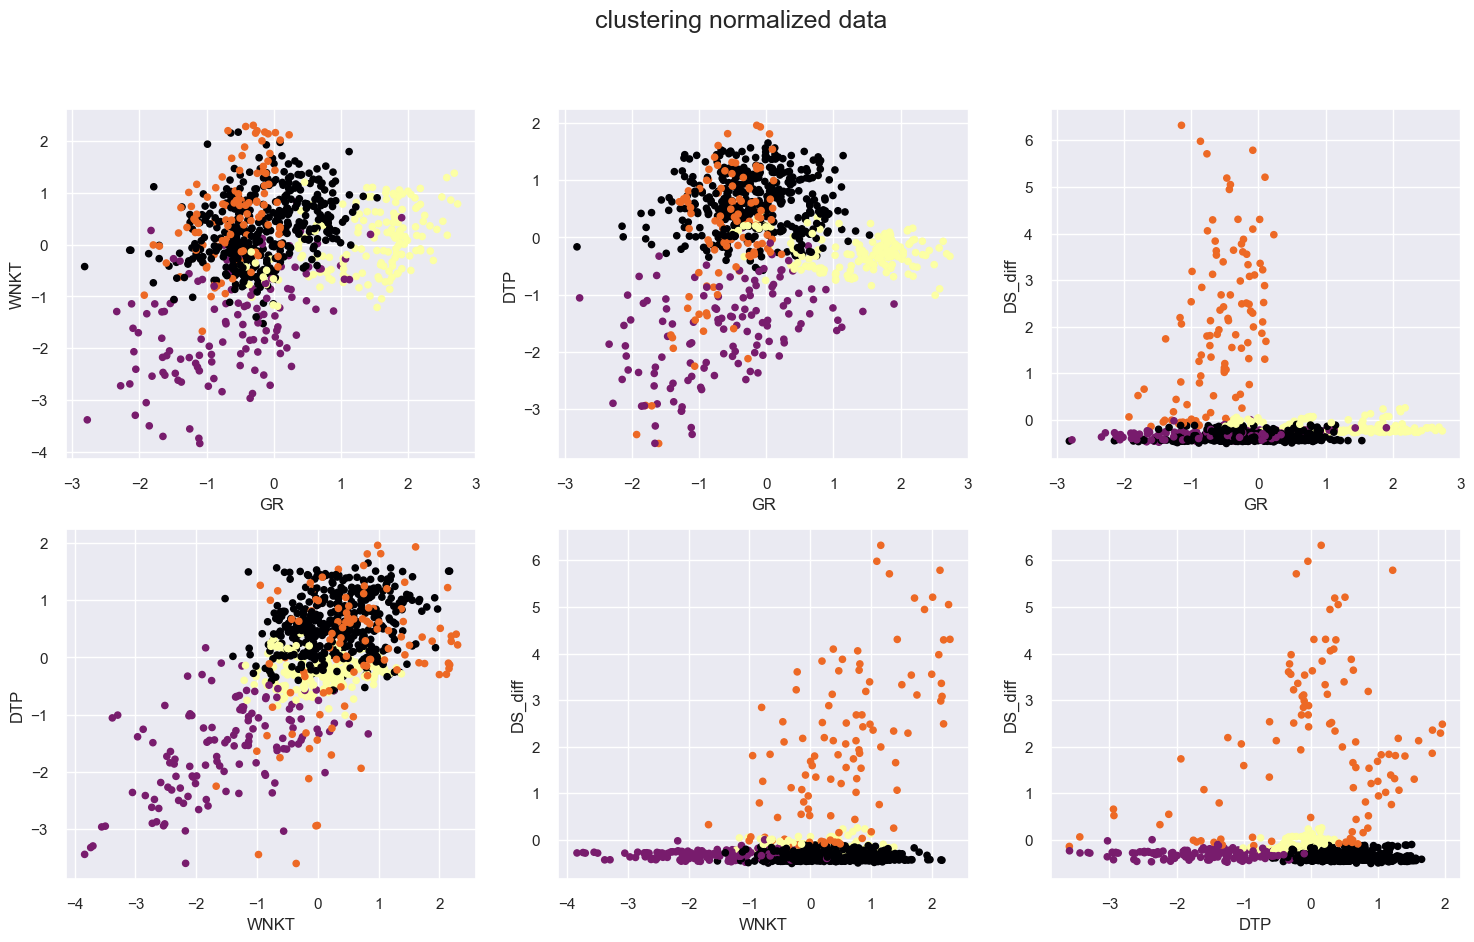

In [191]:
pairs = combinations(std_df, 2)

fig, axes = plt.subplots(2, 3, figsize=(18,10))
for ax, var_pair in zip(axes.flatten(), pairs):
    ax.scatter(std_df[var_pair[0]], std_df[var_pair[1]], c = clusterized['gmm_labels'], s = 20, cmap = 'inferno')
    ax.set_xlabel(var_pair[0])
    ax.set_ylabel(var_pair[1])
plt.suptitle('clustering normalized data', fontsize=18)
plt.show()

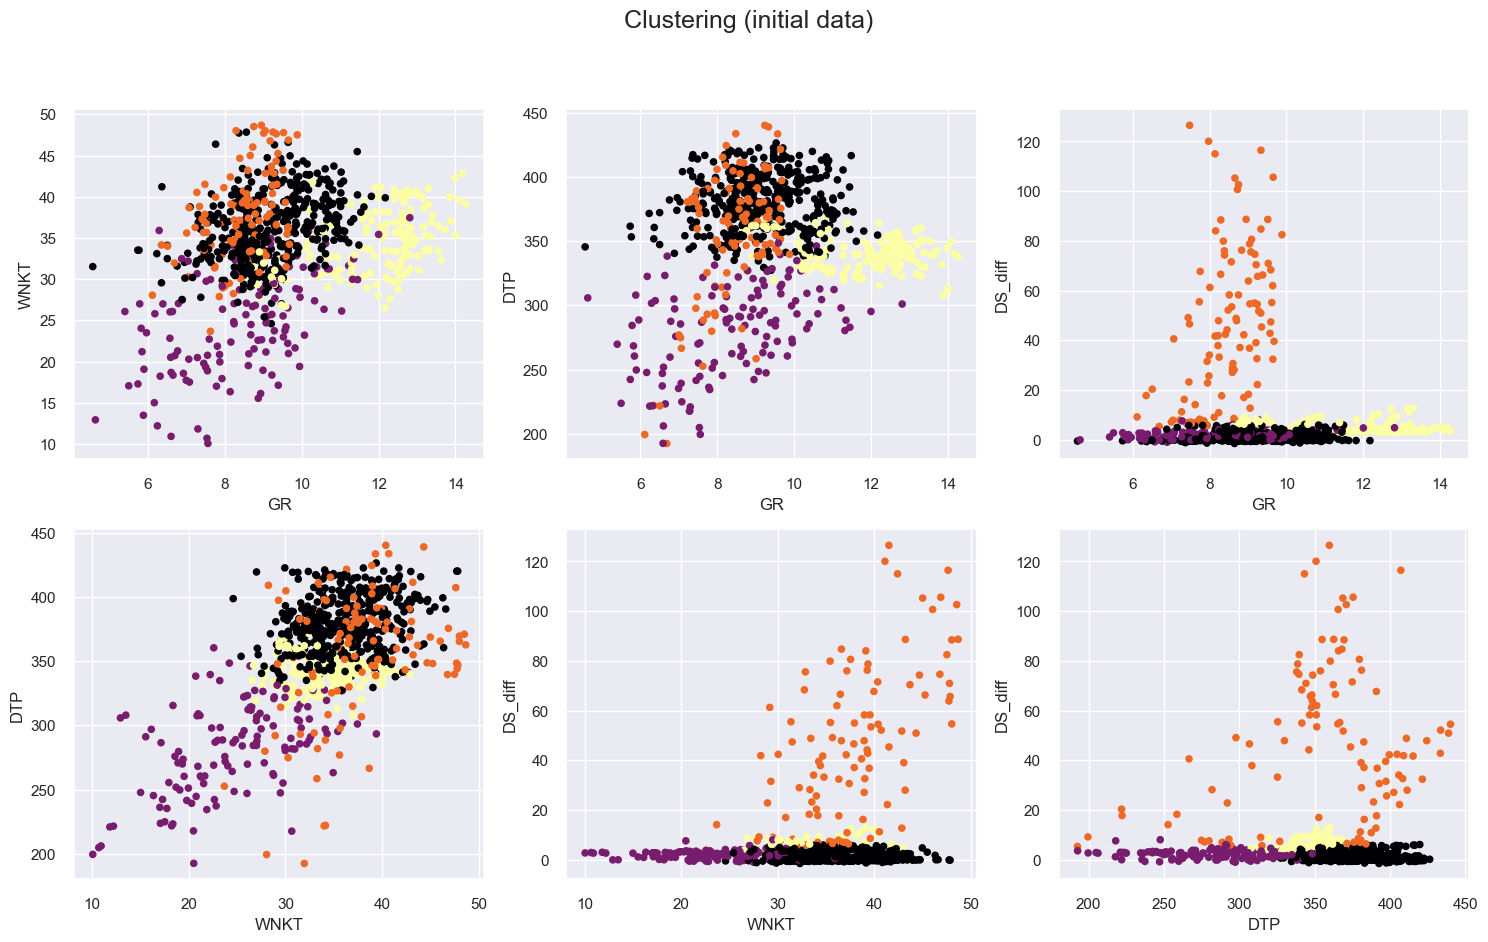

In [192]:
pairs = combinations(clusterized[std_df.columns], 2)

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
for ax, var_pair in zip(axes.flatten(), pairs):
    ax.scatter(clusterized[std_df.columns][var_pair[0]], clusterized[std_df.columns][var_pair[1]],
               c = clusterized['gmm_labels'], s = 20, cmap = 'inferno')
    ax.set_xlabel(var_pair[0])
    ax.set_ylabel(var_pair[1])
plt.suptitle('Clustering (initial data)', fontsize=18)
plt.show()

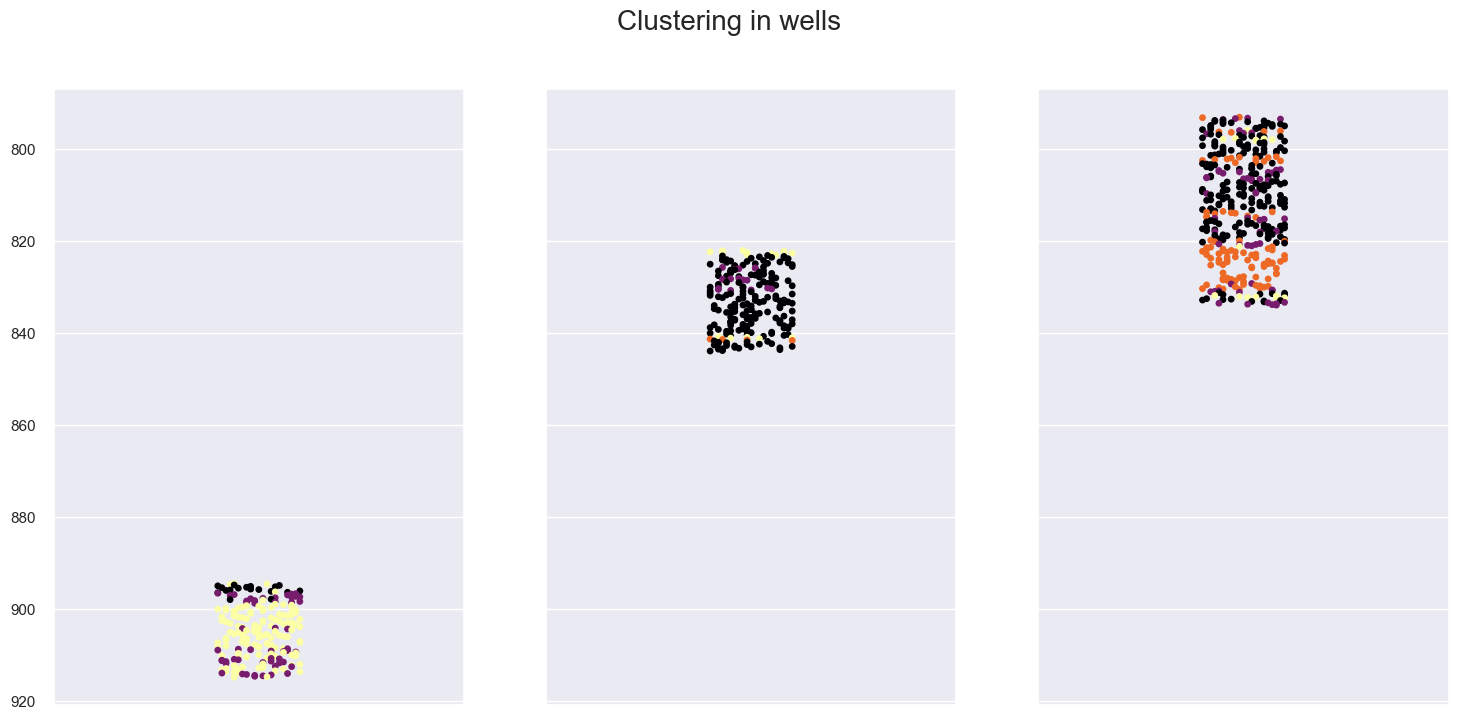

In [193]:
k = 0.2

n_plots = clusterized.well_id.nunique()
n_rows = int(np.ceil(n_plots / 6))

fig, axes = plt.subplots(n_rows, 3, figsize=(18, 8 * n_rows), sharey=True)
for well, ax in zip(clusterized.well_id.unique(), axes.flatten()):
    df_well = clusterized.loc[clusterized.well_id == well].copy()
    df_well['x_coord'] = 1
    df_well.x_coord = df_well['x_coord'].apply(lambda x: x * randint(int(50 - 100 * k/2), int(50 + 100 * k/2)) / 100)
    ax.scatter(df_well.x_coord, df_well.TVD, c=df_well['gmm_labels'], s=15, cmap='inferno')
    ax.set_xlim([0, 1])
    ax.invert_yaxis()
    ax.set_xticks([])
plt.suptitle('Clustering in wells', fontsize=20)
plt.show()

## Hierarchical Clustering (HC)

### Calculation of metrics for different number of clusters

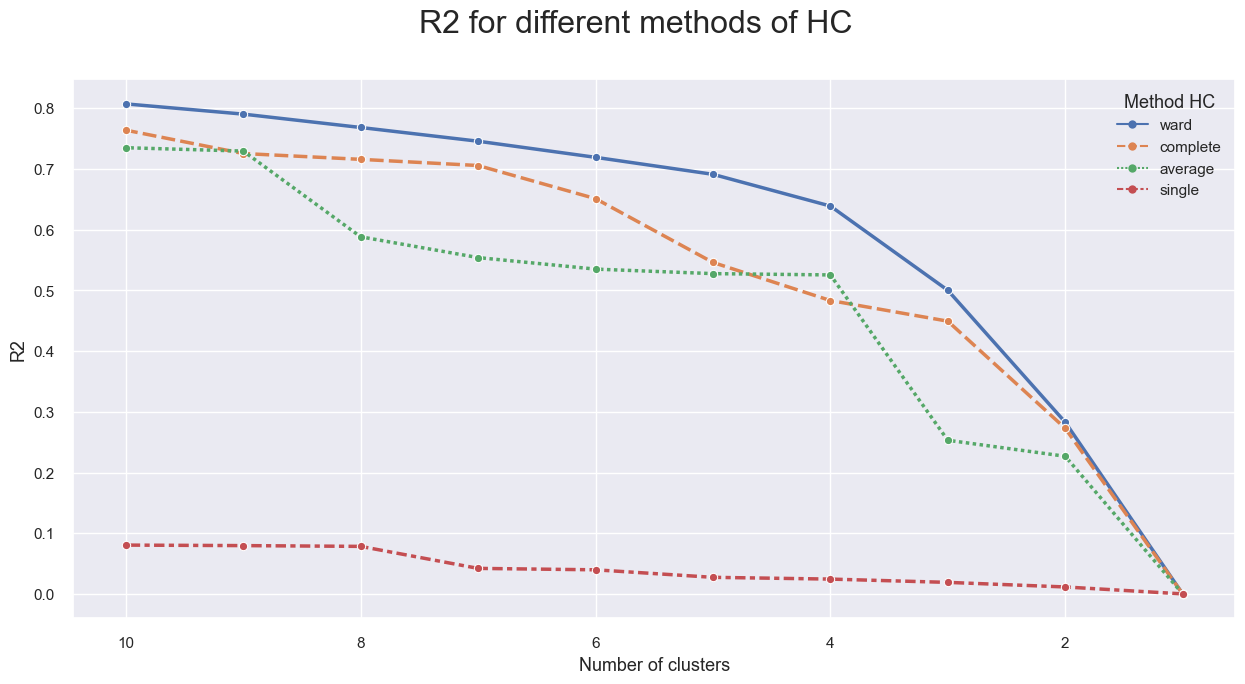

In [194]:
# Prepare input
hc_methods = ["ward", "complete", "average", "single"]
# Function defined above to obtain the R2 statistic
r2_hc_methods = pd.DataFrame(data=np.concatenate([np.expand_dims(get_r2_hc(df=std_df, link=i, max_nclus=10), 1) for i in hc_methods], axis=1),
                             index=range(1,10+1), columns=hc_methods)

sns.set()
# Plot data
fig = plt.figure(figsize=(15,7))
sns.lineplot(data=r2_hc_methods, linewidth=2.5, markers=["o"]*4)

# Finalize the plot
fig.suptitle("R2 for different methods of HC", fontsize=23)
plt.gca().invert_xaxis()
plt.legend(title="Method HC", title_fontsize=13)
plt.xlabel("Number of clusters", fontsize=13)
plt.ylabel("R2", fontsize=13)

plt.show()

In [195]:
# Defining method to use
HCM = "ward"

# Hierarchical clustering assessment using scipy
Z = linkage(std_df, method=HCM)

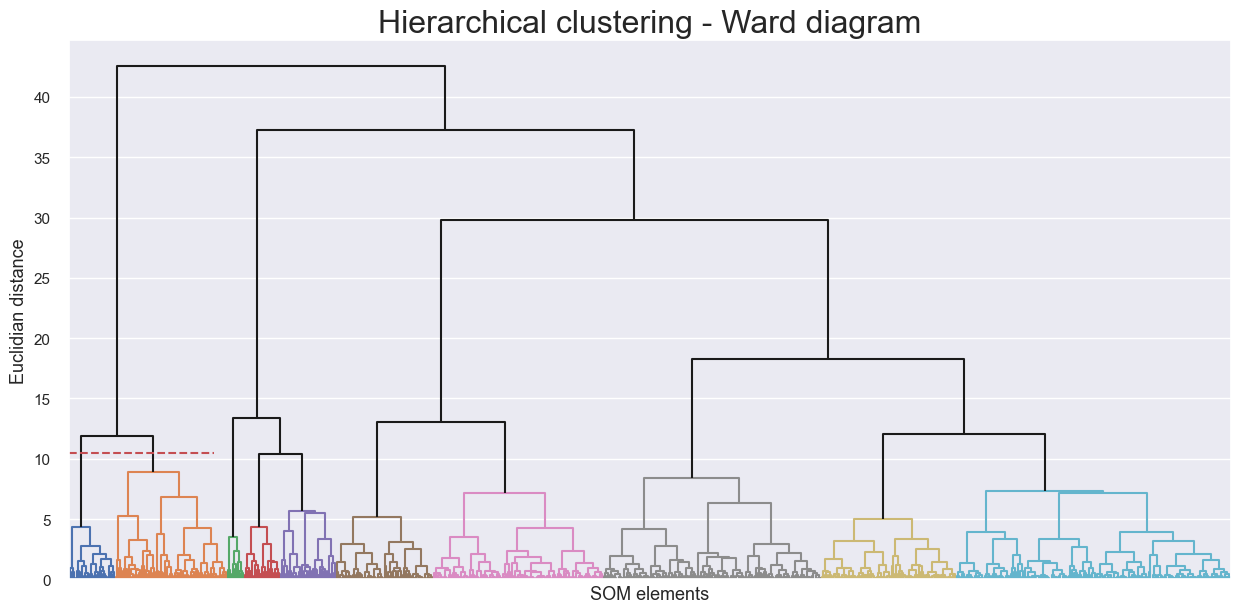

In [196]:
sns.set()
fig = plt.figure(figsize=(15,7))

# Dendrogram
set_link_color_palette(list(sns.color_palette().as_hex()))
dendrogram(Z, color_threshold=10.2, orientation='top', no_labels=True, above_threshold_color='k')

plt.hlines(10.5, 0, 1000, colors="r", linestyles="dashed")
plt.title('Hierarchical clustering - Ward diagram', fontsize=23)
plt.xlabel('SOM elements', fontsize=13)
plt.ylabel('Euclidian distance', fontsize=13)
plt.show()

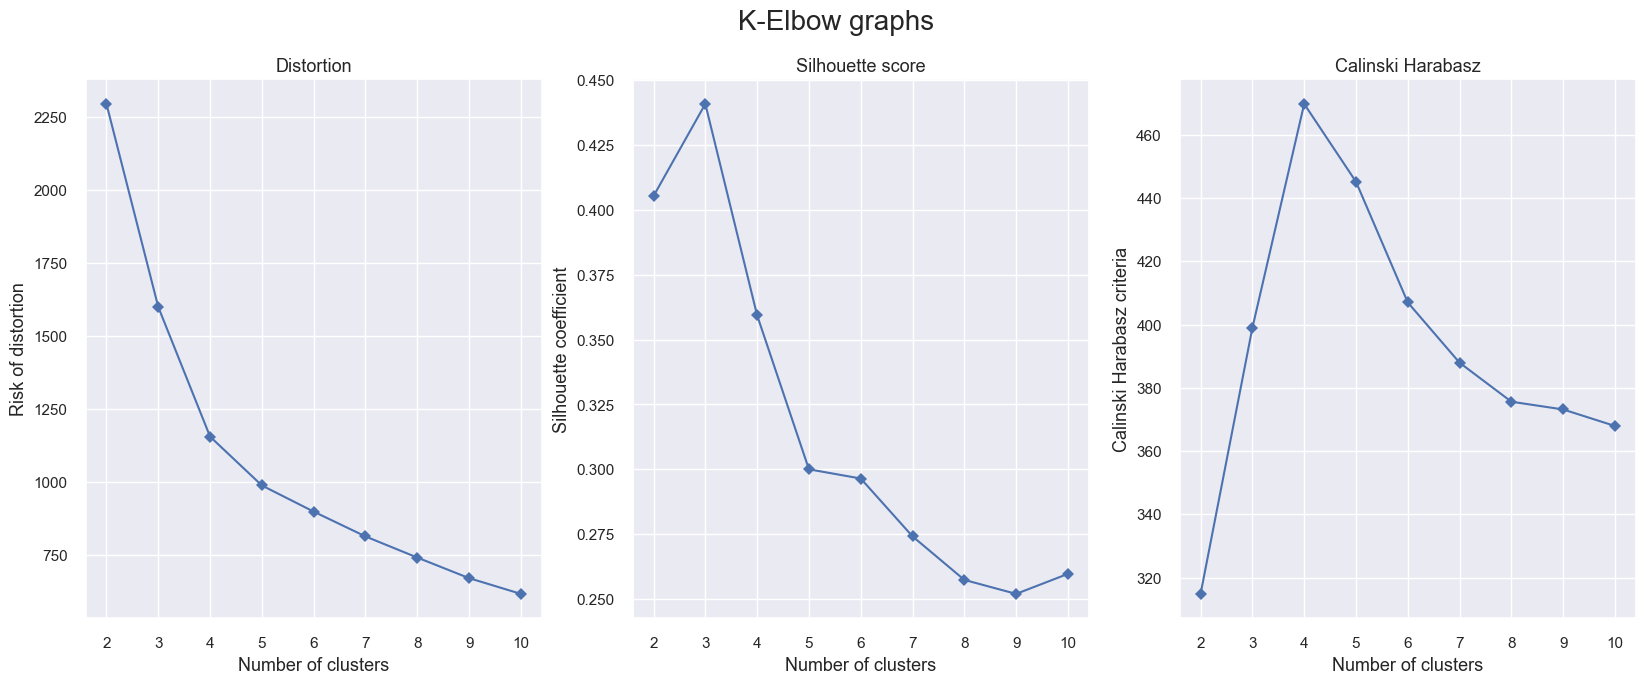

In [197]:
# Hierarchical clustering with sklearn and selected linkage and n_cluster according to plot above and below
Hclustering = AgglomerativeClustering(linkage=HCM)
# K-elbow plots
kelbowplots(Hclustering, std_df)

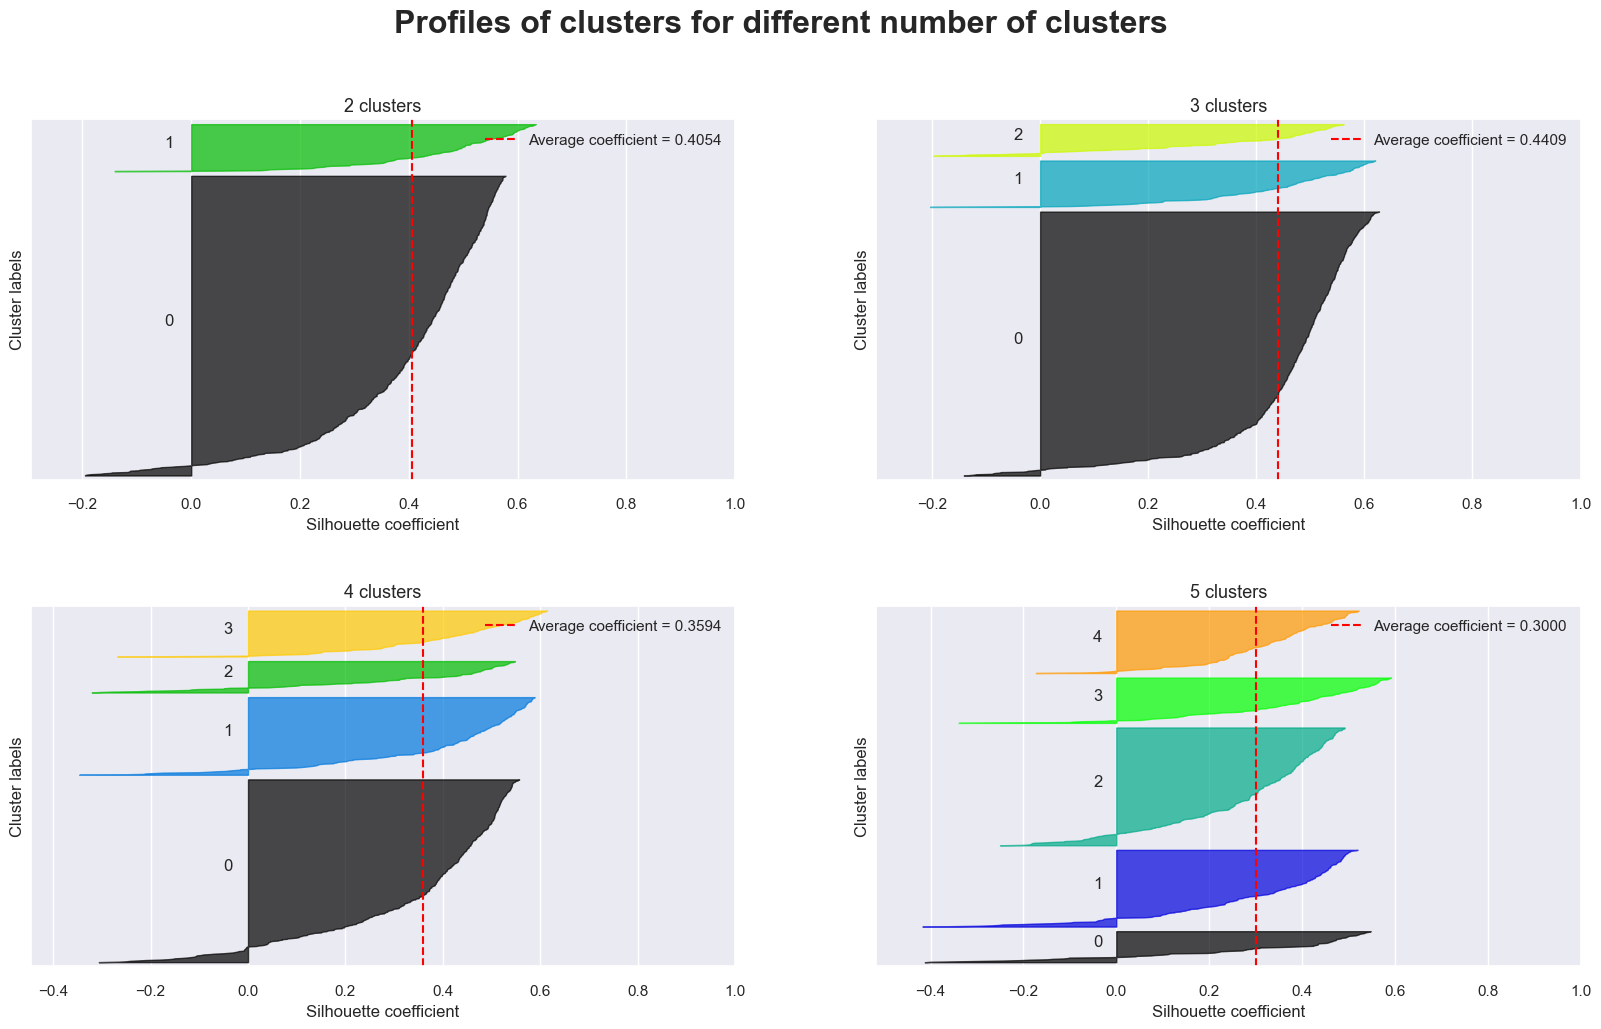

In [198]:
# Function defined above
estimator = AgglomerativeClustering(affinity="euclidean", linkage=HCM)
silhouette_analysis(std_df, estimator, (2,2), (20, 11), 5)

### Clustering

In [199]:
def make_clusters_hc(df):
    model=AgglomerativeClustering(affinity="euclidean", linkage=HCM)
    model.fit(df)
    clust_labels = model.labels_
    return(clust_labels)

In [200]:
# clustering
clusterized["hc_labels"] = make_clusters_hc(std_df)

### Analysis and visualization of results

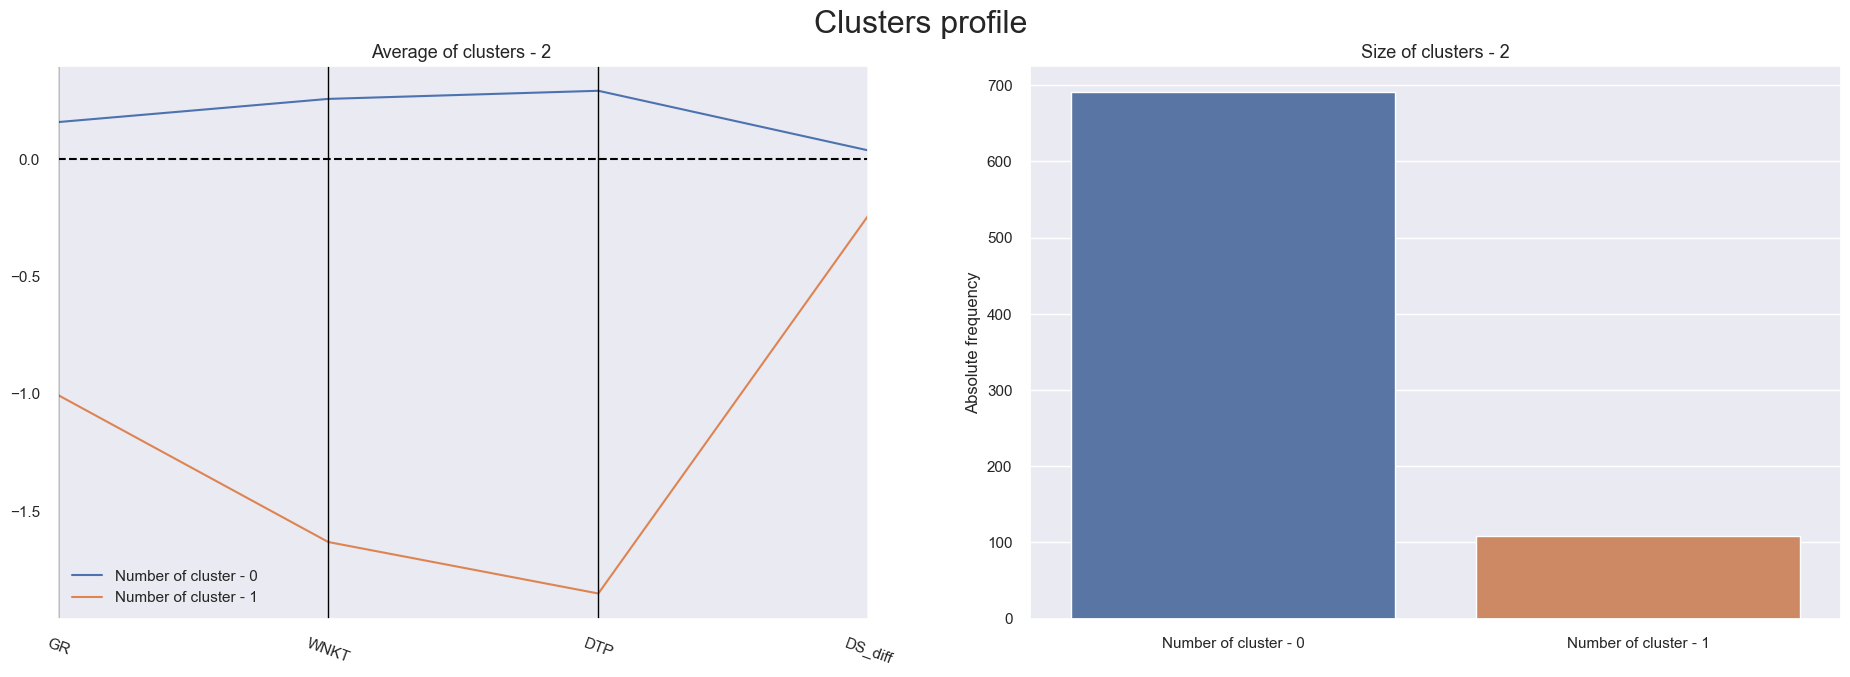

In [201]:
hc_std_df = std_df.copy()
hc_std_df['clusters'] = list(clusterized['hc_labels'])
cluster_profiles(hc_std_df, ["clusters"], (23, 7))

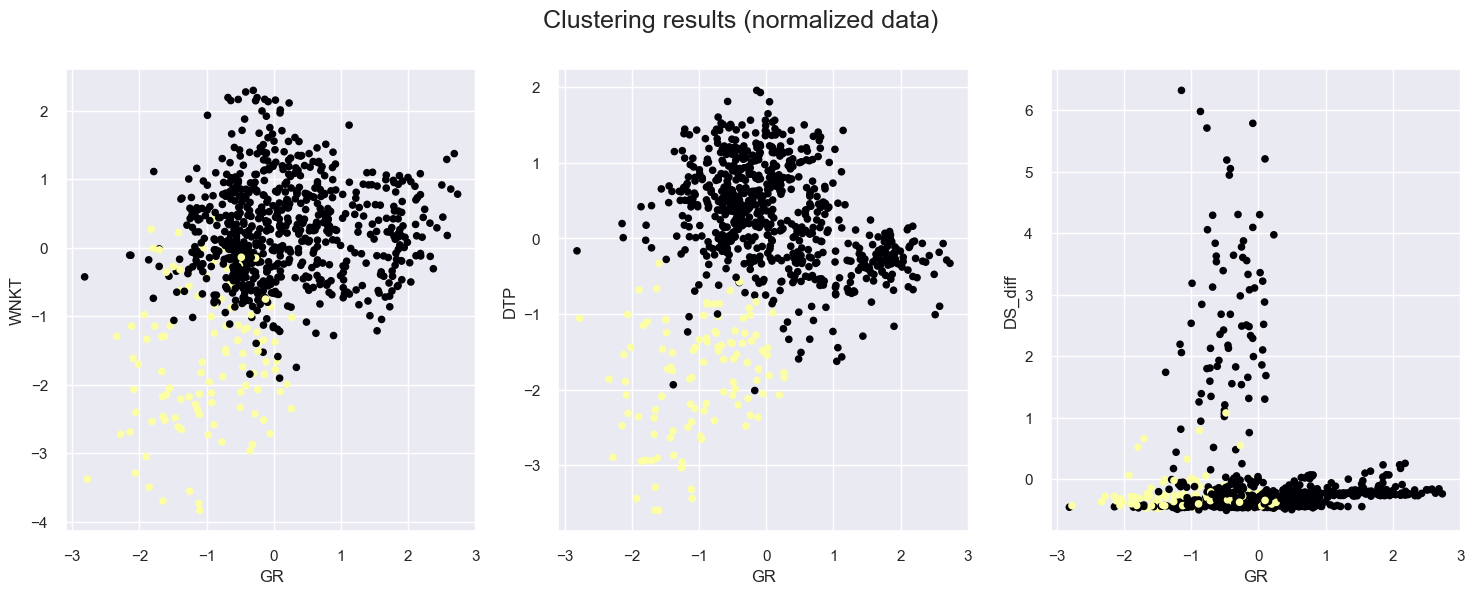

In [202]:
# scatter plot for produced clustering
pairs = combinations(std_df, 2)

fig, axes = plt.subplots(1, 3, figsize=(18,6))
for ax, var_pair in zip(axes, pairs):
    ax.scatter(std_df[var_pair[0]], std_df[var_pair[1]], c = clusterized['hc_labels'], s = 20, cmap = 'inferno')
    ax.set_xlabel(var_pair[0])
    ax.set_ylabel(var_pair[1])
plt.suptitle('Clustering results (normalized data)', fontsize=18)
plt.show()

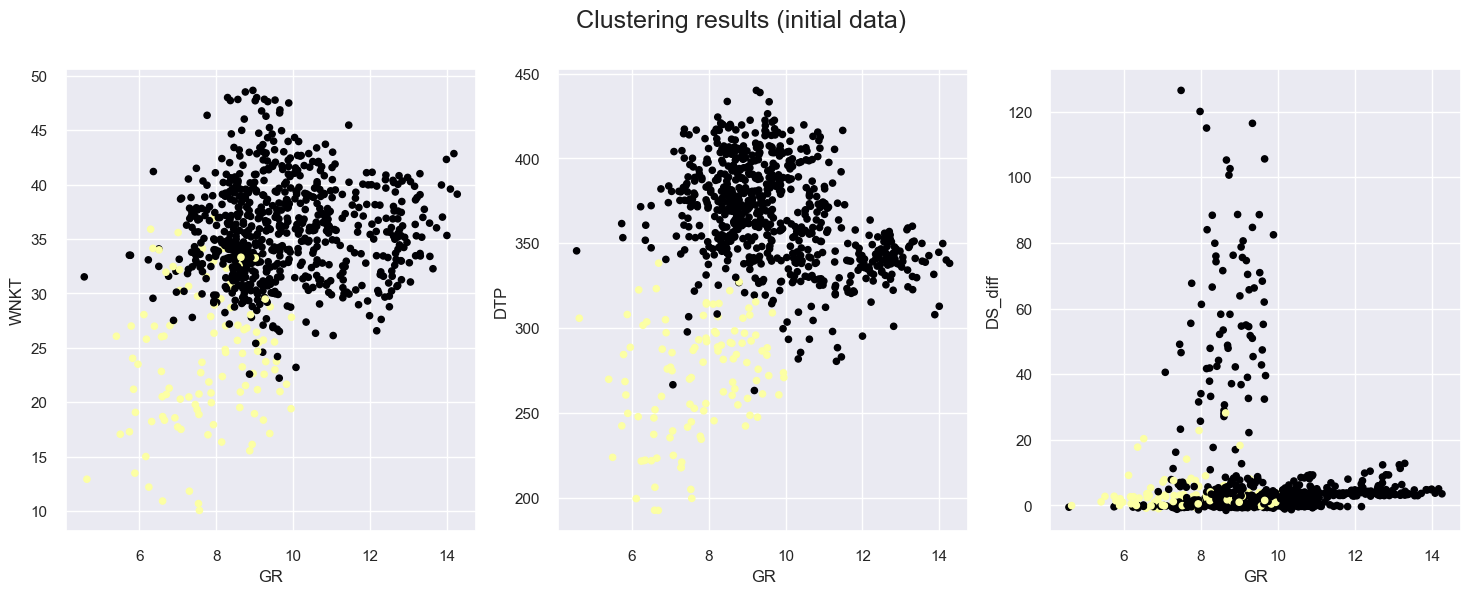

In [203]:
# scatter plot for produced clustering
pairs = combinations(clusterized[std_df.columns], 2)

fig, axes = plt.subplots(1, 3, figsize=(18,6))
for ax, var_pair in zip(axes, pairs):
    ax.scatter(clusterized[std_df.columns][var_pair[0]], clusterized[std_df.columns][var_pair[1]],
               c = clusterized['hc_labels'], s = 20, cmap = 'inferno')
    ax.set_xlabel(var_pair[0])
    ax.set_ylabel(var_pair[1])
plt.suptitle('Clustering results (initial data)', fontsize=18)
plt.show()

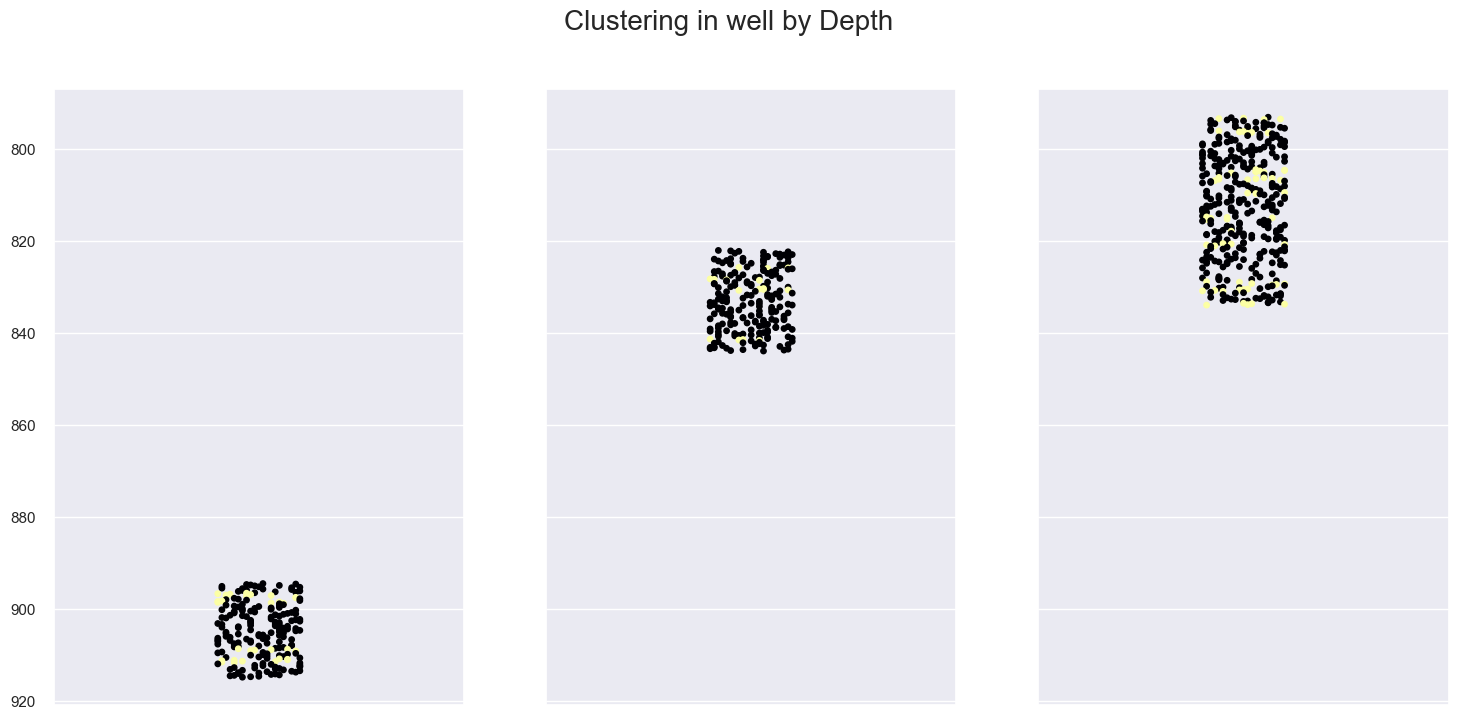

In [204]:
k = 0.2

n_plots = clusterized.well_id.nunique()
n_rows = int(np.ceil(n_plots / 6))

fig, axes = plt.subplots(n_rows, 3, figsize=(18, 8 * n_rows), sharey=True)
for well, ax in zip(clusterized.well_id.unique(), axes.flatten()):
    df_well = clusterized.loc[clusterized.well_id == well].copy()
    df_well['x_coord'] = 1
    df_well.x_coord = df_well['x_coord'].apply(lambda x: x * randint(int(50 - 100 * k/2), int(50 + 100 * k/2)) / 100)
    ax.scatter(df_well.x_coord, df_well.TVD, c=df_well['hc_labels'], s=15, cmap='inferno')
    ax.set_xlim([0, 1])
    ax.invert_yaxis()
    ax.set_xticks([])
plt.suptitle('Clustering in well by Depth', fontsize=20)
plt.show()

## Self-Organizing Maps (SOM) + K-means

In [205]:
#Producing SOM clustering based on proportional product data
sm = SOMFactory().build(data=std_df.values, 
                        mapsize=(10,10),
                        normalization='var',
                        initialization='random',
                        component_names=std_df.columns,
                        lattice='hexa',
                        training='seq')

sm.train(n_job=6,
         verbose=None,
         train_rough_len=100,
         train_finetune_len=100)

#Obtaining SOM's BMUs labels
som_std_df = pd.DataFrame(np.concatenate((sm._data, np.expand_dims(sm._bmu[0],1)), axis=1),
                               index=std_df.index, columns=np.append(std_df.columns,"labels_som"))

print("SOM quantization error: {0:.3f}".format(sm.calculate_quantization_error()))

SOM quantization error: 0.246


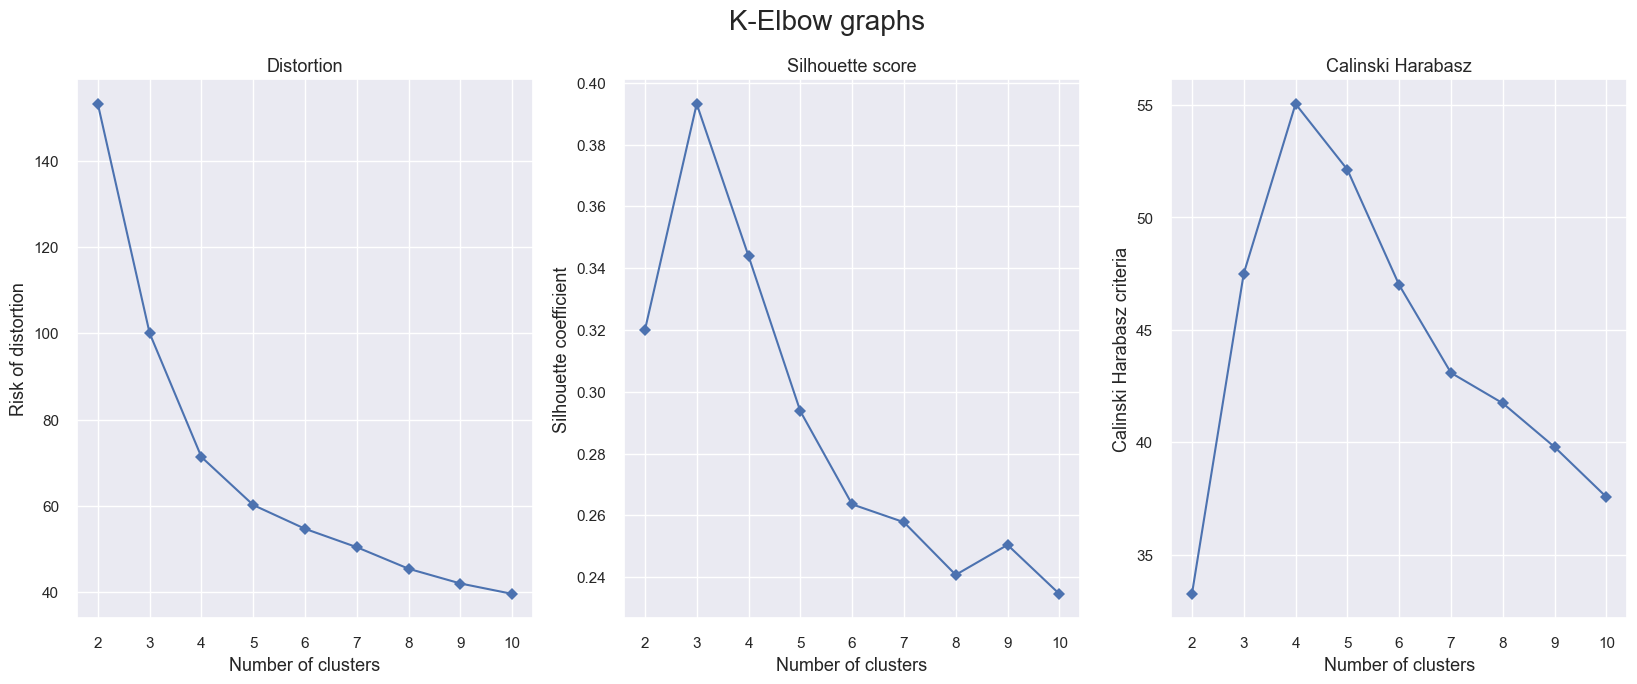

In [206]:
# Hierarchical clustering with sklearn and selected linkage and n_cluster according to plot above and below
Kmeans = KMeans(random_state=0)
# K-elbow plots
som_units = som_std_df.groupby("labels_som").mean()
kelbowplots(Kmeans, som_units)

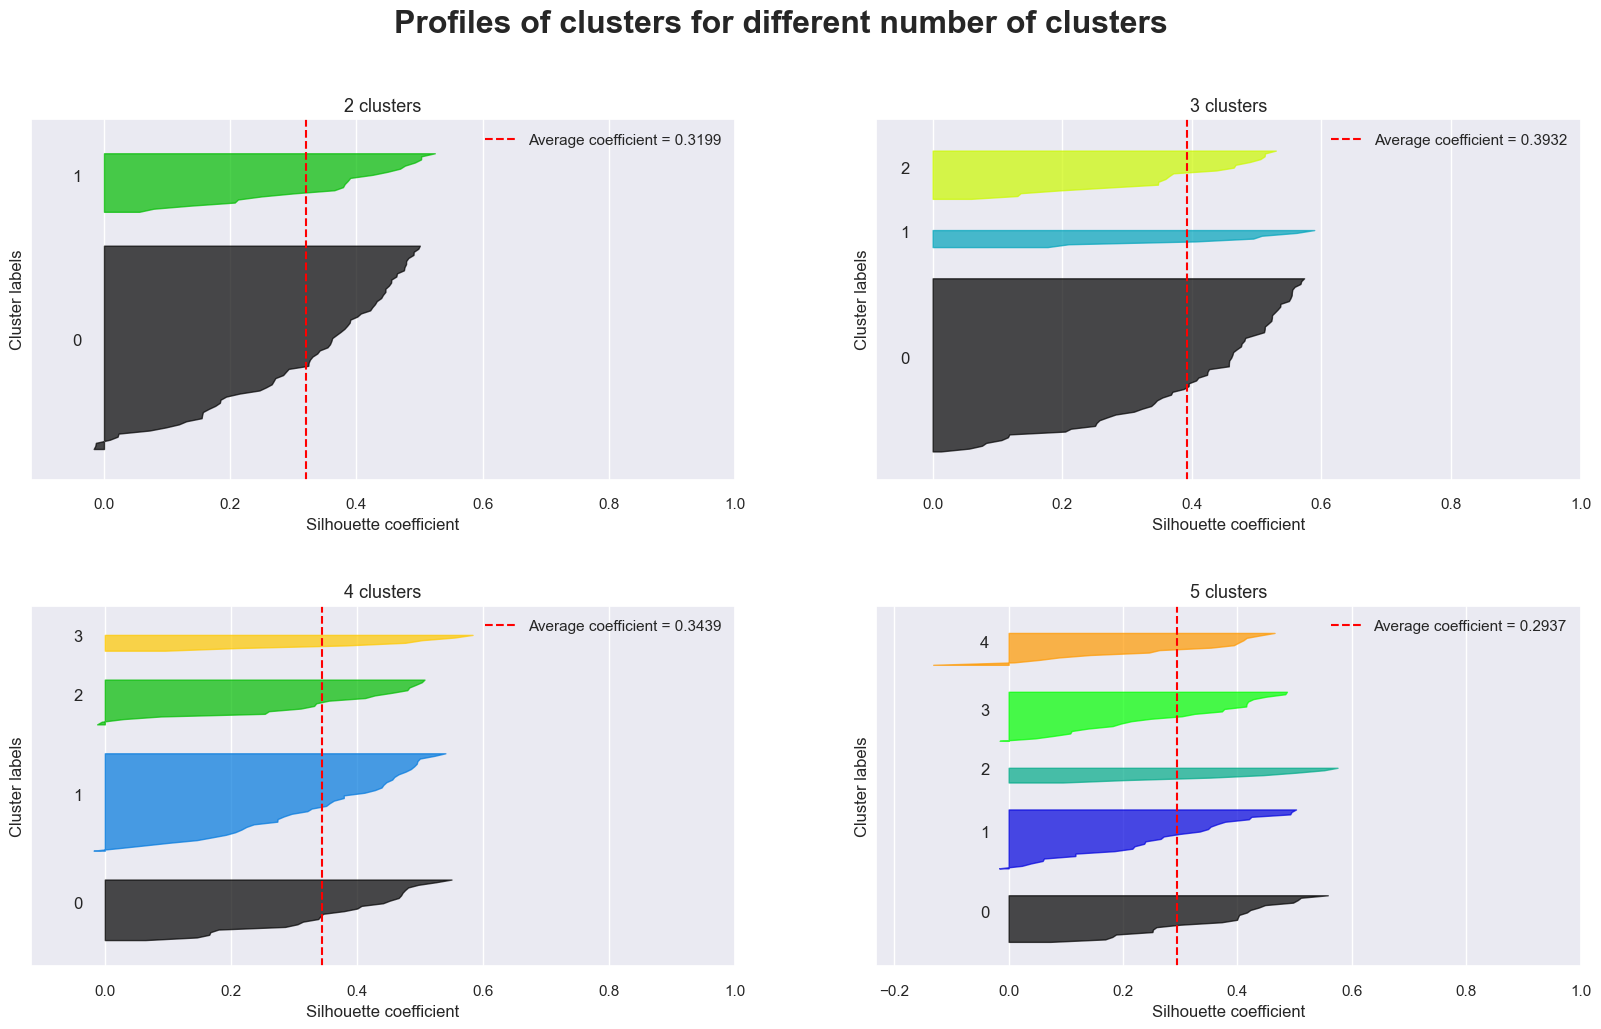

In [207]:
# Function defined above
estimator = KMeans(random_state=0)
silhouette_analysis(som_units, estimator, (2,2), (20, 11), 5)

### Clustering

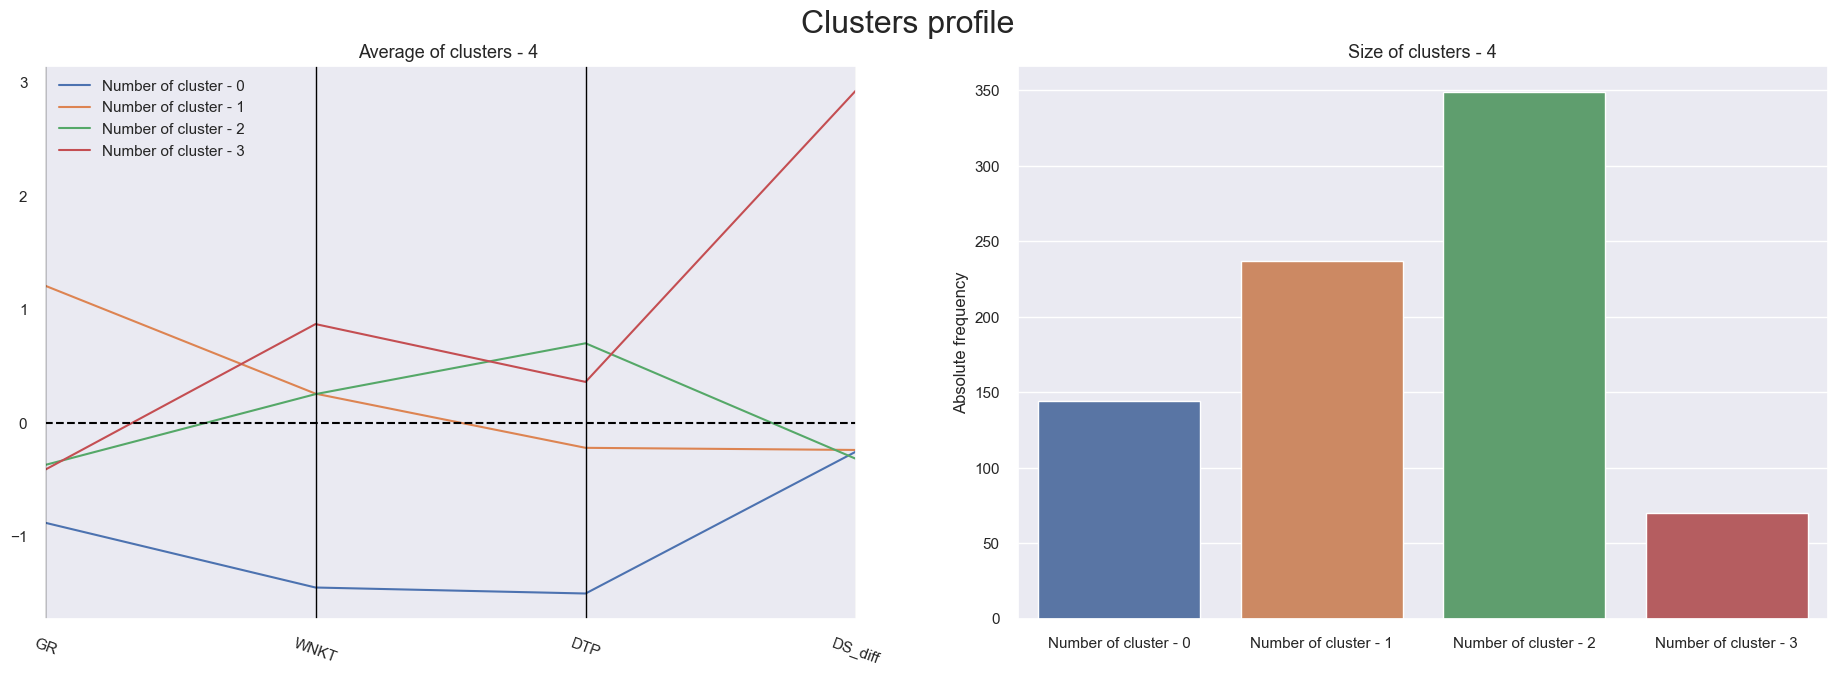

In [208]:
# Defining numbers of clusters
CLUSN = 4

# KMeans with sklearn
estimator = KMeans(n_clusters=CLUSN)
labels = estimator.fit_predict(som_units)

# Getting the KMeans labels for each SOM Unit
som_units_hc = pd.DataFrame(np.concatenate((som_units.values, np.expand_dims(labels,1)), axis=1), 
                            index=som_units.index, columns=np.append(som_units.columns,["labels_som_kmeans_4"]))

# Getting the KMeans labels for each observation in the main dataframe
som_kmeans_prop_df = som_std_df.merge(right=som_units_hc.loc[:,"labels_som_kmeans_4"], 
                                           left_on="labels_som", right_index=True).sort_index()

# Cluster Simple Profilling
cluster_profiles(som_kmeans_prop_df.drop("labels_som", axis=1), ["labels_som_kmeans_4"], (23, 7))

### Analysis and visualization

In [209]:
clusterized['som_kmeans'] = list(som_kmeans_prop_df['labels_som_kmeans_4'])
clusterized['som_kmeans'] = clusterized['som_kmeans'].apply(int)

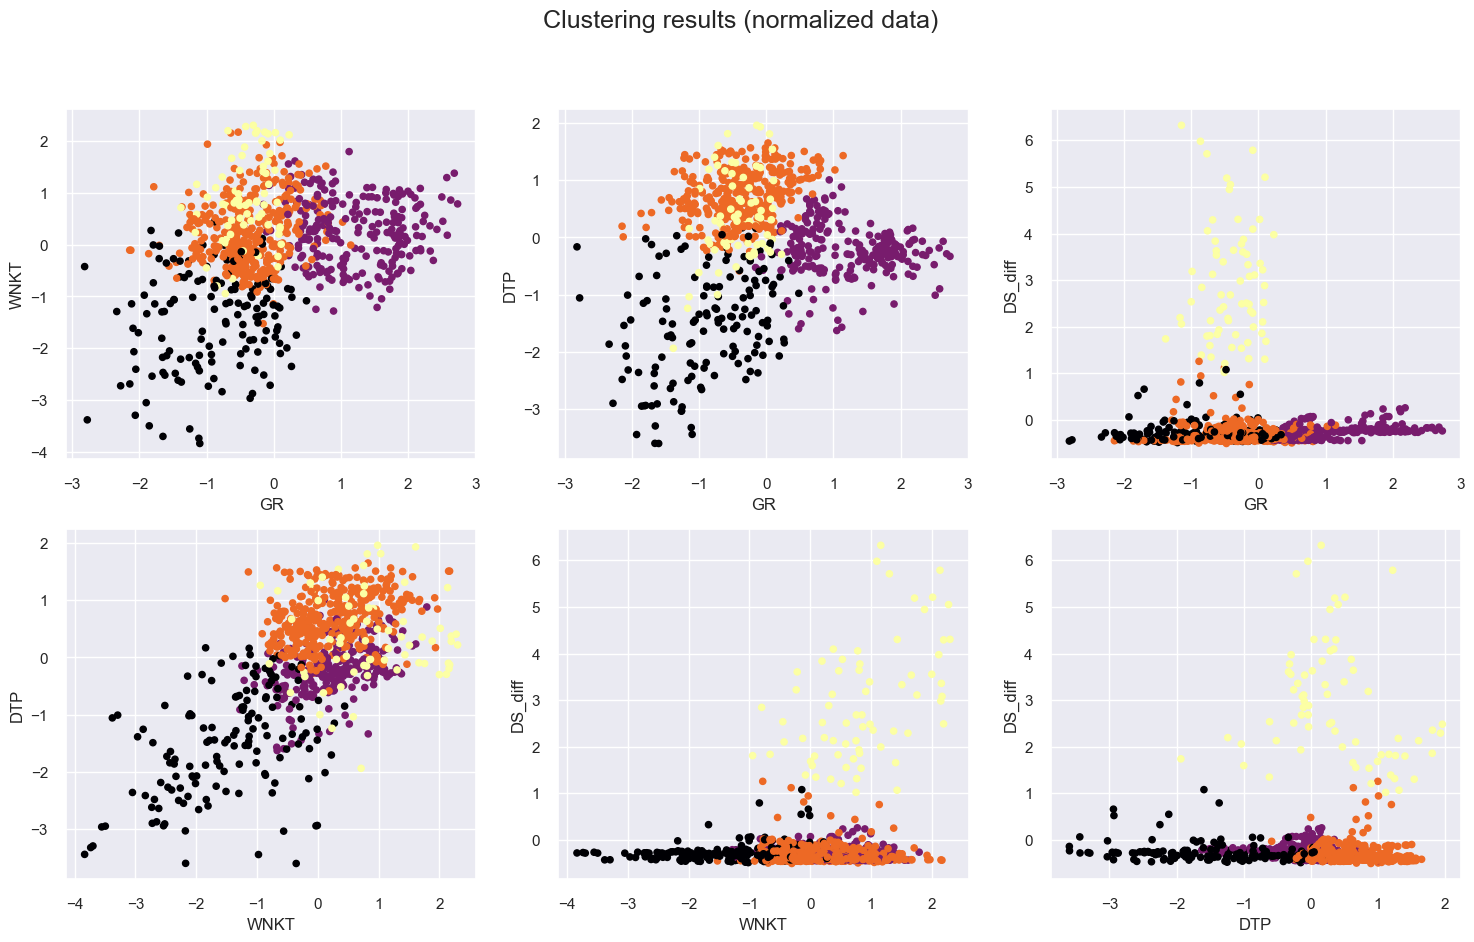

In [210]:
# scatter plot для полученной кластеризации
pairs = combinations(std_df, 2)

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
for ax, var_pair in zip(axes.flatten(), pairs):
    ax.scatter(std_df[var_pair[0]], std_df[var_pair[1]], c = clusterized['som_kmeans'], s = 20, cmap = 'inferno')
    ax.set_xlabel(var_pair[0])
    ax.set_ylabel(var_pair[1])
plt.suptitle('Clustering results (normalized data)', fontsize=18)
plt.show()

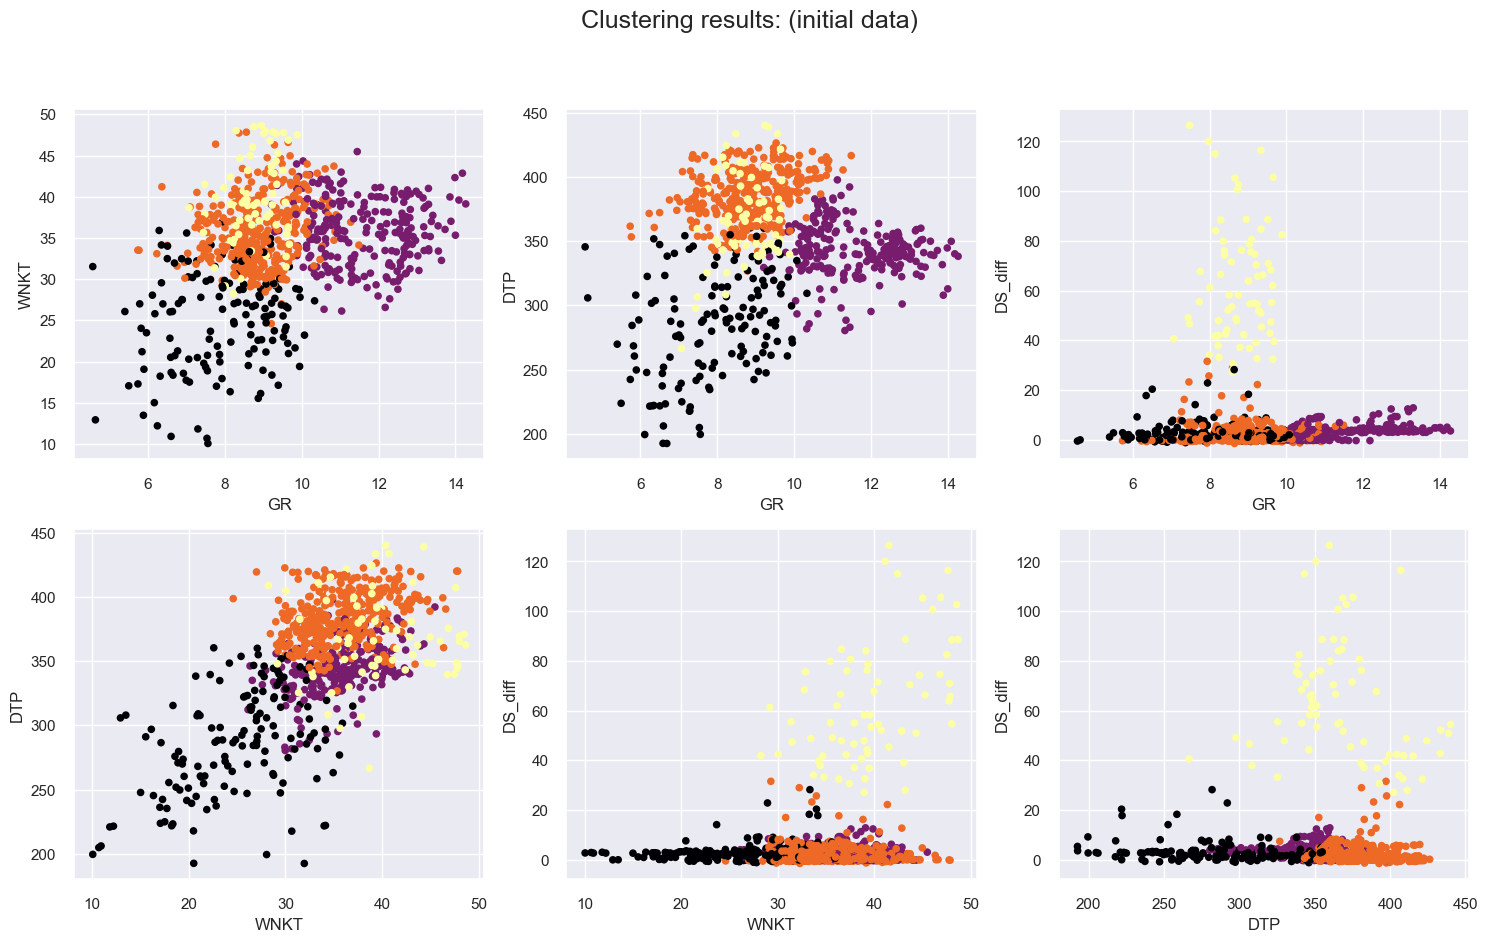

In [211]:
pairs = combinations(clusterized[std_df.columns], 2)

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
for ax, var_pair in zip(axes.flatten(), pairs):
    ax.scatter(clusterized[std_df.columns][var_pair[0]], clusterized[std_df.columns][var_pair[1]],
               c = clusterized['som_kmeans'], s = 20, cmap = 'inferno')
    ax.set_xlabel(var_pair[0])
    ax.set_ylabel(var_pair[1])
plt.suptitle('Clustering results: (initial data)', fontsize=18)
plt.show()

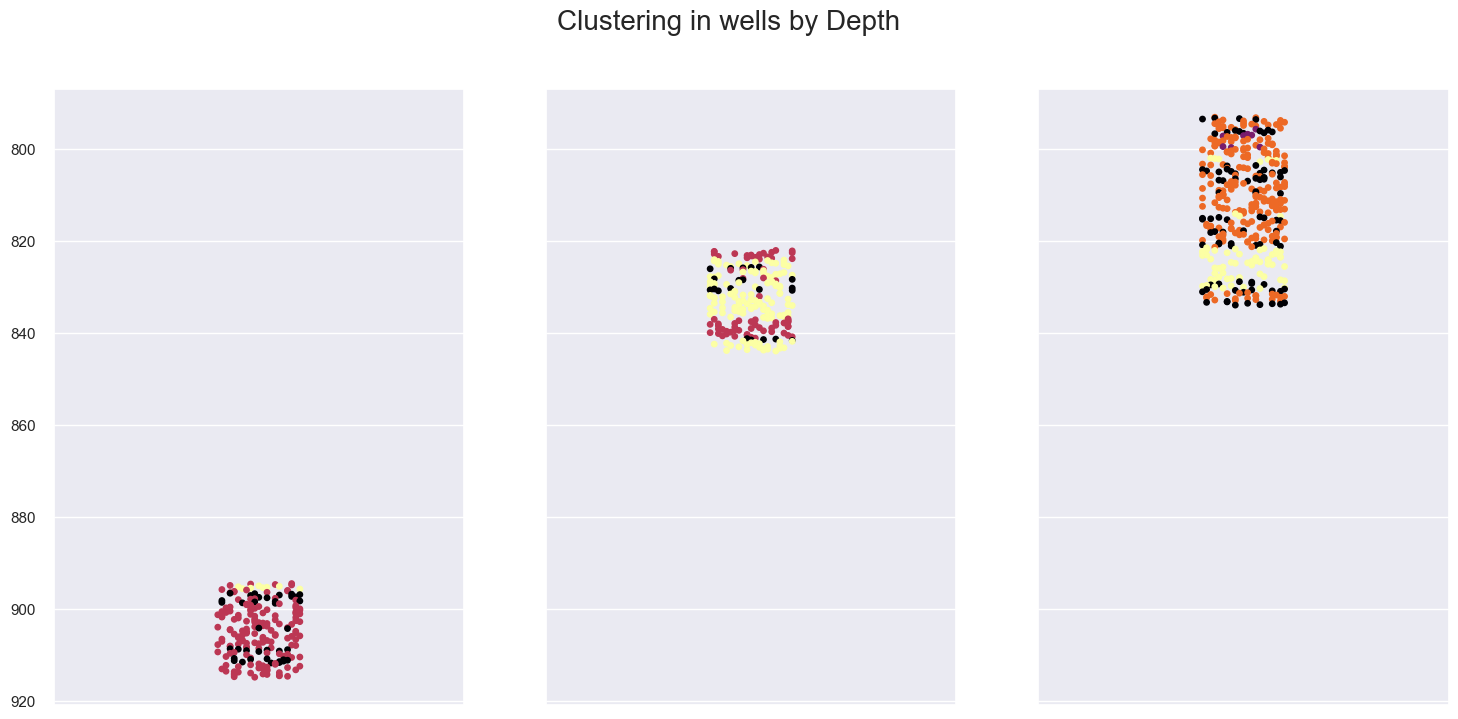

In [212]:
k = 0.2

n_plots = clusterized.well_id.nunique()
n_rows = int(np.ceil(n_plots / 6))

fig, axes = plt.subplots(n_rows, 3, figsize=(18, 8 * n_rows), sharey=True)
for well, ax in zip(clusterized.well_id.unique(), axes.flatten()):
    df_well = clusterized.loc[clusterized.well_id == well].copy()
    df_well['x_coord'] = 1
    df_well.x_coord = df_well['x_coord'].apply(lambda x: x * randint(int(50 - 100 * k/2), int(50 + 100 * k/2)) / 100)
    ax.scatter(df_well.x_coord, df_well.TVD, c=df_well['som_kmeans'], s=15, cmap='inferno')
    ax.set_xlim([0, 1])
    ax.invert_yaxis()
    ax.set_xticks([])
plt.suptitle('Clustering in wells by Depth', fontsize=20)
plt.show()

# Save results

In [213]:
clusterized.head(5)

GR    WNKT      DTP  DS_diff well_id      TVD  id  kmeans_labels  \
0  11.988  27.955  342.777    2.887   UZ_21  894.555   0              3   
1  11.292  29.602  345.329    2.528   UZ_21  894.655   1              3   
2  10.933  32.643  351.024    2.514   UZ_21  894.755   2              3   
3  11.074  35.878  356.438    2.429   UZ_21  894.855   3              3   
4  10.927  37.447  362.087    2.356   UZ_21  894.955   4              3   

   gmm_labels  hc_labels  som_kmeans  
0           3          0           1  
1           3          0           1  
2           3          0           1  
3           0          0           1  
4           0          0           1

In [214]:
clusterized.drop(columns=['id'], inplace=True)
clusterized.to_excel('../xlsx/full_data_clusterized_4_features_initial.xlsx')